# Re-Run Analyses with Polka et. al. Subset

In [1]:
from datetime import timedelta, date
from pathlib import Path
import sys

from cairosvg import svg2png
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import ConnectionPatch
from mizani.breaks import date_breaks
from mizani.formatters import timedelta_format
import numpy as np
import pandas as pd
import plotnine as p9
import requests
from scipy.spatial.distance import cdist
from scipy.stats import linregress
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import spacy
import tqdm

from annorxiver_modules.corpora_comparison_helper import (
    aggregate_word_counts,
    calculate_confidence_intervals,
    create_lemma_count_df,
    get_term_statistics,
    plot_bargraph,
    plot_point_bar_figure,
    plot_pointgraph,
)

sys.path.append(str(Path("../../../preprint_similarity_search/server").resolve()))
from SAUCIE import SAUCIE, Loader  # noqa: E402

mpl.rcParams["figure.dpi"] = 600
mpl.rcParams["font.size"] = 12
mpl.rcParams["font.family"] = "Arial"

In [2]:
import rpy2.robjects as robjects  # noqa: E402
from rpy2.robjects import pandas2ri  # noqa: E402

In [3]:
from rpy2.robjects.packages import importr  # noqa: E402

utils = importr("utils")
utils.install_packages("svglite")

R[write to console]: Installing package into ‘/home/danich1/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/svglite_2.0.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 122260 bytes (119 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write 

<rpy2.rinterface_lib.sexp.NULLType object at 0x7f1c4595f388> [RTYPES.NILSXP]

# Corpora Comparison Preprint-Published Update

## BioRxiv to Published Mapping

In [4]:
mapped_doi_df = (
    pd.read_csv("../journal_tracker/output/mapped_published_doi.tsv", sep="\t")
    .query("published_doi.notnull()")
    .query("pmcid.notnull()")
    .groupby("preprint_doi")
    .agg(
        {
            "author_type": "first",
            "heading": "first",
            "category": "first",
            "document": "first",
            "preprint_doi": "last",
            "published_doi": "last",
            "pmcid": "last",
        }
    )
    .reset_index(drop=True)
)
mapped_doi_df.head()

,author_type,heading,category,document,preprint_doi,published_doi,pmcid
0,regular article,new results,genetics,000026_v1.xml,10.1101/000026,10.1371/journal.pgen.1004412,PMC4125079
1,regular article,new results,genomics,000042_v1.xml,10.1101/000042,10.1038/nrg3723,PMC4151119
2,regular article,new results,genomics,000067_v1.xml,10.1101/000067,10.1038/nature12904,PMC4285441
3,regular article,new results,evolutionary biology,000109_v1.xml,10.1101/000109,10.1371/journal.pgen.1004410,PMC4072524
4,regular article,new results,cancer biology,000125_v1.xml,10.1101/000125,10.1016/j.ejca.2014.08.019,PMC4258103


In [5]:
polka_et_al_mapped_df = pd.read_csv(
    "output/polka_et_al_pmc_mapped_subset.tsv", sep="\t"
)
polka_et_al_mapped_df.head()

,biorxiv_doi,published_doi,PMID,PMCID,Version,MID,IsCurrent,IsLive,ReleaseDate,Msg
0,10.1101/2019.12.18.881391,10.1128/JVI.00426-20,32295925.0,PMC7307142,NaN,NaN,NaN,1,NaN,NaN
1,10.1101/2019.12.19.882274,10.3389/fpls.2020.00355,32373138.0,PMC7176908,NaN,NaN,NaN,1,NaN,NaN
2,10.1101/2020.01.13.905190,10.1182/blood.2019002867,32128578.0,PMC7243144,NaN,NaN,NaN,1,NaN,NaN
3,10.1101/2020.01.21.914929,10.1128/AAC.00086-20,32284379.0,PMC7269492,NaN,NaN,NaN,1,NaN,NaN
4,10.1101/2020.01.22.914952,10.1038/s41586-020-2012-7,32015507.0,PMC7095418,NaN,NaN,NaN,1,NaN,NaN


In [6]:
spacy_nlp = spacy.load("en_core_web_sm")
stop_word_list = list(spacy_nlp.Defaults.stop_words)

## BioRxiv Token Counts

In [7]:
polka_preprints = list(Path("output/biorxiv_word_counts").rglob("*tsv"))

In [8]:
preprint_count = aggregate_word_counts(polka_preprints)

preprint_count_df = (
    pd.DataFrame.from_records(
        [
            {
                "lemma": token[0],
                "pos_tag": token[1],
                "dep_tag": token[2],
                "count": preprint_count[token],
            }
            for token in preprint_count
        ]
    )
    .query(f"lemma not in {stop_word_list}")
    .groupby("lemma")
    .agg({"count": "sum"})
    .reset_index()
    .sort_values("count", ascending=False)
)

preprint_count_df.head()

,lemma,count
27,-pron-,3568
3950,cell,2042
13007,sars,1350
14977,use,1309
11917,protein,1288


## PMCOA Token Counts

In [9]:
polka_published = list(Path("output/pmcoa_word_counts").rglob("*tsv"))

In [10]:
published_count = aggregate_word_counts(polka_published)

published_count_df = (
    pd.DataFrame.from_records(
        [
            {
                "lemma": token[0],
                "pos_tag": token[1],
                "dep_tag": token[2],
                "count": published_count[token],
            }
            for token in published_count
        ]
    )
    .query(f"lemma not in {stop_word_list}")
    .groupby("lemma")
    .agg({"count": "sum"})
    .reset_index()
    .sort_values("count", ascending=False)
)

published_count_df.head()

,lemma,count
25,-pron-,2817
8,,1511
12813,sars,1451
4643,cell,1409
11765,protein,1028


## Get Token Stats

In [11]:
preprint_vs_published = get_term_statistics(published_count_df, preprint_count_df, 100)
preprint_vs_published.to_csv(
    "output/updated_preprint_to_published_comparison.tsv", sep="\t", index=False
)
preprint_vs_published

,lemma,corpus_one_a,corpus_two_b,corpus_one_c,corpus_two_d,log_likelihood,odds_ratio
0,cov,706,930,141685,185461,0.016011,0.993689
1,pcr,156,165,141685,185461,3.625419,1.237569
2,residue,157,220,141685,185461,0.426479,0.934127
3,suggest,218,336,141685,185461,3.560634,0.849270
4,model,215,287,141685,185461,0.047220,0.980585
...,...,...,...,...,...,...,...
111,genome,204,296,141685,185461,1.286876,0.902126
112,surface,90,261,141685,185461,47.217012,0.451368
113,observe,231,361,141685,185461,4.468444,0.837594
114,time,198,303,141685,185461,2.947474,0.855365


In [12]:
full_plot_df = calculate_confidence_intervals(preprint_vs_published)
full_plot_df.to_csv(
    "output/polka_preprint_published_comparison_error_bars.tsv", sep="\t", index=False
)
full_plot_df.head()

,lemma,corpus_one_a,corpus_two_b,corpus_one_c,corpus_two_d,log_likelihood,odds_ratio,lower_odds,upper_odds,z_value,p_value
0,cov,706,930,141685,185461,0.016011,0.993689,0.900854,1.096091,-0.126515,0.449662
1,pcr,156,165,141685,185461,3.625419,1.237569,0.994178,1.540546,1.907735,0.028213
2,residue,157,220,141685,185461,0.426479,0.934127,0.761070,1.146533,-0.651879,0.257240
3,suggest,218,336,141685,185461,3.560634,0.849270,0.716072,1.007245,-1.877063,0.030255
4,model,215,287,141685,185461,0.047220,0.980585,0.821579,1.170365,-0.217201,0.414026


In [13]:
plot_df = (
    full_plot_df.sort_values("odds_ratio", ascending=False)
    .iloc[4:]
    .head(20)
    .append(full_plot_df.sort_values("odds_ratio", ascending=True).head(20))
    .assign(
        odds_ratio=lambda x: x.odds_ratio.apply(lambda x: np.log2(x)),
        lower_odds=lambda x: x.lower_odds.apply(lambda x: np.log2(x)),
        upper_odds=lambda x: x.upper_odds.apply(lambda x: np.log2(x)),
    )
)
plot_df.head()

,lemma,corpus_one_a,corpus_two_b,corpus_one_c,corpus_two_d,log_likelihood,odds_ratio,lower_odds,upper_odds,z_value,p_value
27,cov-2,770,599,141685,185461,91.801123,0.750731,0.596354,0.905108,9.531431,7.756526e-22
11,line,272,229,141685,185461,24.286774,0.636688,0.382893,0.890483,4.916992,4.394205e-07
63,supplementary,189,161,141685,185461,16.087404,0.619754,0.316326,0.923182,4.003317,3.123029e-05
30,filament,165,141,141685,185461,13.861653,0.615200,0.290752,0.939648,3.716438,1.010255e-04
64,bead,191,164,141685,185461,15.721769,0.608306,0.307113,0.909498,3.958524,3.770713e-05


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 8.5 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/preprint_published_frequency_odds.svg
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 8.5 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/preprint_published_frequency_odds.png


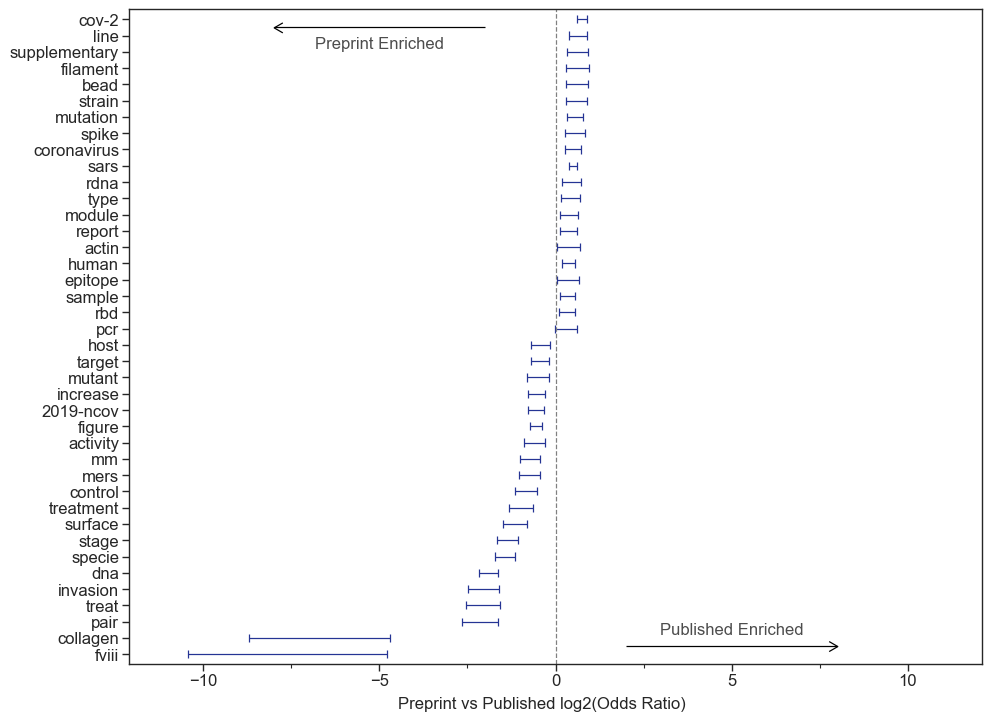

<ggplot: (8779722668878)>


In [14]:
g = plot_pointgraph(
    plot_df,
    x_axis_label="Preprint vs Published log2(Odds Ratio)",
    left_arrow_label="Preprint Enriched",
    right_arrow_label="Published Enriched",
    left_arrow_start=-2,
    left_arrow_height=39.5,
    right_arrow_start=2,
    right_arrow_height=1.5,
    arrow_length=6,
    left_arrow_label_x=-5,
    left_arrow_label_y=38.5,
    right_arrow_label_x=5,
    right_arrow_label_y=2.5,
    limits=(-11, 11),
)

g.save("output/figures/preprint_published_frequency_odds.svg")
g.save("output/figures/preprint_published_frequency_odds.png", dpi=250)
print(g)

In [14]:
count_plot_df = create_lemma_count_df(plot_df, "published", "preprint").assign(
    repository=lambda x: pd.Categorical(
        x.repository.tolist(), categories=["preprint", "published"]
    )
)
count_plot_df.to_csv(
    "output/polka_preprint_published_comparison_raw_counts.tsv", sep="\t", index=False
)
count_plot_df.head()

,lemma,count,repository
0,cov-2,770,published
1,line,272,published
2,supplementary,189,published
3,filament,165,published
4,bead,191,published


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 8.5 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/preprint_published_frequency_bar.svg


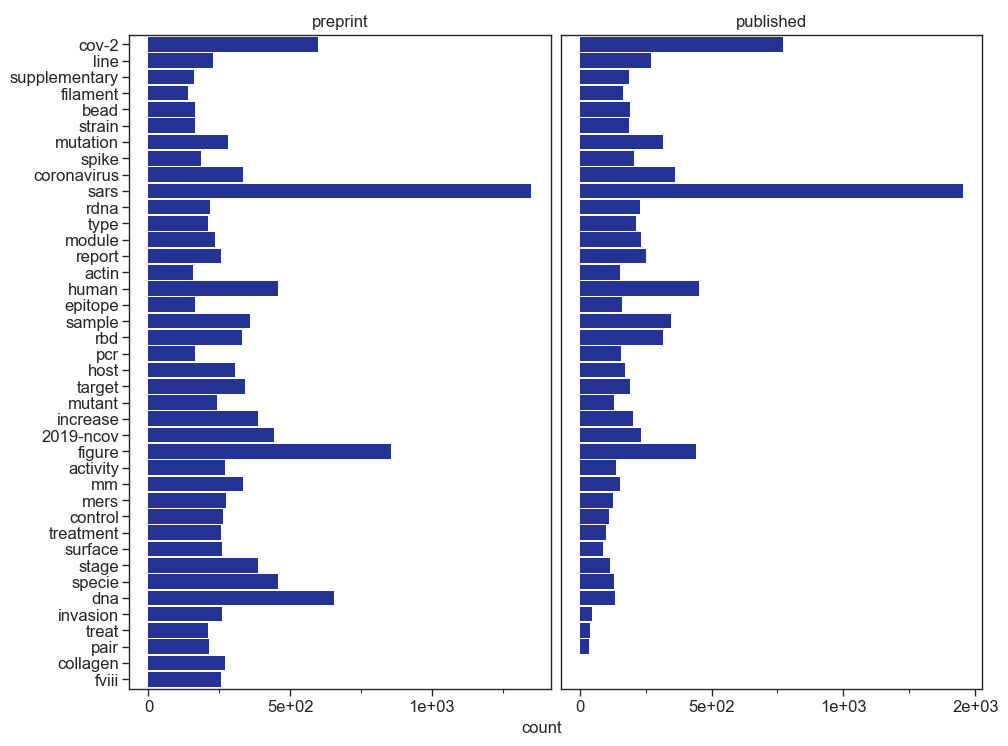

<ggplot: (-9223363263465351287)>


In [15]:
g = plot_bargraph(count_plot_df, plot_df)
g.save("output/figures/preprint_published_frequency_bar.svg")
print(g)

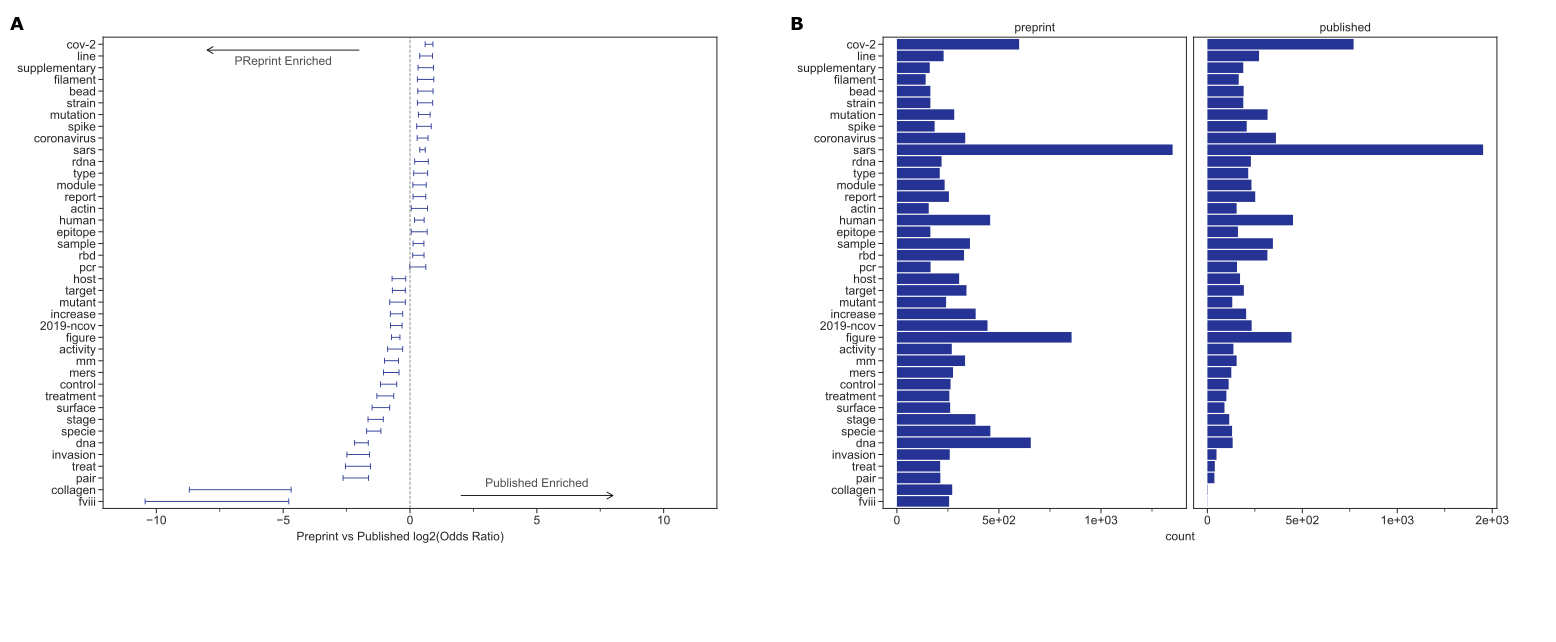

In [16]:
fig_output_path = "output/figures/polka_preprint_published_frequency.png"

fig = plot_point_bar_figure(
    "output/figures/preprint_published_frequency_odds.svg",
    "output/figures/preprint_published_frequency_bar.svg",
)

# save generated SVG files
svg2png(bytestring=fig.to_str(), write_to=fig_output_path, dpi=75)

Image(fig_output_path)

# Document Embeddings

## Load the Documents

In [17]:
biorxiv_documents_df = pd.read_csv(
    "../word_vector_experiment/output/word2vec_output/biorxiv_all_articles_300.tsv.xz",
    sep="\t",
)
biorxiv_documents_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,440735_v1.xml,0.063813,0.012187,-0.156229,-0.158987,0.165480,-0.346612,0.001741,-0.107139,0.684055,...,-0.140772,-0.143405,-0.081427,-0.248220,-0.771470,-0.235455,0.547801,0.859663,-0.063151,0.012667
1,775270_v1.xml,-0.201064,0.011870,-0.354809,-0.150633,0.095305,-0.507254,-0.339986,0.303313,0.944561,...,-0.115199,-0.259798,0.272955,-0.346138,-0.844158,-0.596267,0.121678,0.959160,-0.747369,-0.073314
2,242404_v1.xml,-0.204741,-0.107589,-0.062853,0.140793,0.066307,-0.463290,-0.106492,-0.040269,0.557687,...,-0.229839,-0.325765,-0.064586,-0.300529,-0.707948,-0.479390,0.381809,0.968333,-0.402499,-0.109250
3,872994_v1.xml,-0.256990,-0.055972,-0.300816,0.495731,0.290070,-0.310817,-0.481578,-0.161373,0.483896,...,0.148916,-0.217426,0.195183,-0.069086,-0.545689,-0.517949,0.265230,0.645038,-0.843499,-0.142928
4,080853_v2.xml,0.167641,0.046808,-0.709753,0.232242,-0.139213,-0.319284,-0.314807,0.310180,0.317704,...,0.540693,0.264286,0.256323,0.137184,-0.754344,-0.145583,0.032544,0.507430,-0.374320,0.473060


In [18]:
polka_preprints_df = pd.read_csv("output/polka_et_al_biorxiv_embeddings.tsv", sep="\t")
polka_preprints_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,838870_v1.xml,-0.236496,-0.158390,-0.137343,-0.001011,-0.284048,-0.271869,0.041991,0.120466,0.264844,...,0.125062,-0.135080,0.170882,-0.308521,-0.600287,-0.345592,0.039640,0.730110,-0.348575,0.372932
1,2020.02.13.945485_v1.xml,-0.209540,0.062120,-0.013421,-0.000279,-0.314423,-0.326985,0.110545,0.243373,0.338386,...,-0.119528,0.035750,-0.064431,-0.094898,-0.711048,-0.044813,0.324615,0.655335,-0.402705,0.460434
2,2020.01.13.905190_v1.xml,0.229247,0.103720,-0.675217,-0.279651,0.141527,-0.414926,-0.125090,0.169768,0.501925,...,0.282492,0.042949,0.182784,-0.178214,-0.292325,0.067889,0.266495,0.434768,-0.672433,0.628961
3,865089_v1.xml,0.259484,0.187865,-0.476495,0.104272,-0.239906,-0.327997,0.087983,0.278655,0.548521,...,0.273547,0.442512,0.137913,-0.376542,-0.662379,-0.009104,0.152630,0.026150,-0.478900,0.473070
4,832675_v1.xml,0.331504,0.397300,-0.662221,-0.082239,0.142704,-0.483719,-0.225434,0.289693,0.750071,...,0.357520,0.031200,0.369862,-0.425790,-0.461598,-0.768766,0.229174,0.504789,-0.708815,0.094324


In [19]:
pca_components = pd.read_csv(
    Path("../pca_association_experiment/output/word_pca_similarity/pca_components.tsv"),
    sep="\t",
)
pca_components.head()

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,-0.049104,-0.022952,0.054169,0.054761,0.035576,-0.010399,-0.024812,-0.048933,0.017739,0.088210,...,-0.074235,-0.055353,-0.008411,0.026470,-0.026992,-0.032384,0.035687,0.070615,-0.018170,-0.097132
1,-0.025294,0.025114,0.044676,-0.124849,-0.057298,0.006263,0.074133,0.061397,-0.021857,-0.091527,...,-0.007480,0.028617,-0.049084,0.024782,-0.013106,-0.007171,0.008073,0.068401,0.101262,0.096735
2,0.034591,0.073876,0.081714,-0.064158,-0.041002,0.021764,0.103048,-0.014965,0.015615,0.116552,...,-0.013544,0.064324,-0.055909,-0.069447,-0.112860,-0.091762,0.000651,0.036475,0.057296,-0.083348
3,-0.049435,-0.079498,0.022533,0.082681,-0.078703,-0.024764,0.031693,0.042404,-0.034200,0.026995,...,-0.001326,-0.103326,0.053888,-0.101415,0.046668,-0.087855,-0.108510,0.035366,-0.099735,-0.005285
4,-0.089308,0.008366,-0.053669,-0.040672,0.089469,0.001333,-0.082718,-0.011179,0.005334,-0.017407,...,0.053544,-0.001412,0.052857,0.052416,-0.038935,-0.116536,-0.033255,0.131235,0.050803,-0.013997


## PCA Components

This section aims to see which principal components have a high association with Polka et al's subset. Furthermore, we also aim to see if we can use linear models to explain which PCs affect preprint prediction.

In [20]:
document_pca_sim = 1 - cdist(
    polka_preprints_df.drop("document", axis=1).values, pca_components.values, "cosine"
)
print(document_pca_sim.shape)
document_pca_sim

(60, 50)


array([[ 0.48535459,  0.32769718, -0.11702601, ..., -0.00708894,
        -0.1763098 ,  0.07093126],
       [ 0.40229859,  0.40125141, -0.11295513, ..., -0.02142173,
        -0.17558446,  0.03351737],
       [-0.13201049,  0.00422107, -0.23458851, ..., -0.05661229,
        -0.17898195,  0.03952835],
       ...,
       [ 0.0705537 , -0.05343738, -0.11530624, ..., -0.05205647,
        -0.16128802,  0.08376136],
       [ 0.45579515,  0.07217712,  0.10180552, ..., -0.02012594,
        -0.17641599,  0.04301979],
       [-0.14215926,  0.01035352, -0.30403885, ...,  0.00640834,
        -0.16529912,  0.07293628]])

In [21]:
document_to_pca_map = {
    document: document_pca_sim[idx, :]
    for idx, document in enumerate(polka_preprints_df.document.tolist())
}

In [22]:
polka_pca_sim_df = (
    pd.DataFrame.from_dict(document_to_pca_map, orient="index")
    .rename(index=str, columns={col: f"pc{col+1}" for col in range(int(300))})
    .reset_index()
    .rename(index=str, columns={"index": "document"})
)
polka_pca_sim_df.to_csv("output/polka_pca_enrichment.tsv", sep="\t")
polka_pca_sim_df = polka_pca_sim_df.assign(label="polka")
polka_pca_sim_df.head()

,document,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50,label
0,838870_v1.xml,0.485355,0.327697,-0.117026,0.060002,0.082892,-0.231834,0.197279,0.070949,0.119728,...,-0.069344,0.165091,-0.035076,0.041742,-0.171587,-0.054242,-0.007089,-0.176310,0.070931,polka
1,2020.02.13.945485_v1.xml,0.402299,0.401251,-0.112955,-0.007803,0.054732,-0.152136,0.128697,0.066135,0.106593,...,-0.055381,0.137845,-0.052355,-0.007101,-0.126582,-0.095786,-0.021422,-0.175584,0.033517,polka
2,2020.01.13.905190_v1.xml,-0.132010,0.004221,-0.234589,-0.219427,0.206070,-0.214871,0.319344,-0.104184,-0.028459,...,-0.079103,0.145765,-0.021315,0.017914,-0.155084,-0.097257,-0.056612,-0.178982,0.039528,polka
3,865089_v1.xml,-0.003473,-0.226553,0.008652,-0.157976,-0.058406,-0.240677,0.286005,0.124532,0.017155,...,-0.108278,0.208805,-0.014241,0.049448,-0.196724,-0.040389,-0.031915,-0.173311,0.086573,polka
4,832675_v1.xml,0.005197,-0.018107,-0.089304,-0.150317,0.281778,-0.286903,0.368157,-0.105521,0.043050,...,-0.042351,0.151861,-0.028407,0.018610,-0.126058,-0.075546,0.045653,-0.168079,0.083449,polka


In [23]:
document_pca_sim = 1 - cdist(
    biorxiv_documents_df.drop("document", axis=1).values,
    pca_components.values,
    "cosine",
)
print(document_pca_sim.shape)
document_pca_sim

(98023, 50)


array([[ 5.95956613e-01,  2.06706195e-01,  9.36058605e-02, ...,
        -1.74995744e-02, -1.12026820e-01,  4.46913364e-02],
       [ 5.69433259e-01,  6.83818727e-02,  5.45734659e-02, ...,
        -1.02481269e-02, -1.35967212e-01,  4.86130998e-02],
       [ 6.52165870e-01,  2.17111783e-01,  8.10198554e-03, ...,
        -2.55193981e-02, -1.45718071e-01,  3.05497144e-02],
       ...,
       [ 5.21728268e-01,  2.44131460e-01,  6.56794993e-02, ...,
        -8.87029548e-03, -1.30719912e-01,  7.86368055e-02],
       [ 4.36705115e-01,  1.11214632e-01, -3.31904336e-01, ...,
        -1.67141755e-04, -1.24753268e-01,  6.87804124e-02],
       [ 4.59887641e-01,  7.69425710e-03,  1.00356951e-01, ...,
         5.65001628e-03, -1.46776846e-01,  3.68038862e-02]])

In [24]:
document_to_pca_map = {
    document: document_pca_sim[idx, :]
    for idx, document in enumerate(biorxiv_documents_df.document.tolist())
}

In [25]:
biorxiv_pca_sim_df = (
    pd.DataFrame.from_dict(document_to_pca_map, orient="index")
    .rename(index=str, columns={col: f"pc{col+1}" for col in range(int(300))})
    .reset_index()
    .rename(index=str, columns={"index": "document"})
    .assign(label="biorxiv")
)
biorxiv_pca_sim_df.head()

,document,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50,label
0,440735_v1.xml,0.595957,0.206706,0.093606,-0.231033,0.044339,-0.245114,0.236109,-0.068330,-0.049427,...,-0.069338,0.143821,-0.014357,0.006164,-0.122359,-0.041935,-0.017500,-0.112027,0.044691,biorxiv
1,775270_v1.xml,0.569433,0.068382,0.054573,-0.072618,0.214168,-0.014034,0.368566,-0.046566,0.141556,...,-0.068422,0.146787,-0.011100,-0.012195,-0.160199,-0.082186,-0.010248,-0.135967,0.048613,biorxiv
2,242404_v1.xml,0.652166,0.217112,0.008102,-0.099959,0.054900,-0.300635,0.269288,-0.019824,-0.022865,...,-0.073117,0.149957,-0.041281,-0.008557,-0.086613,-0.039287,-0.025519,-0.145718,0.030550,biorxiv
3,872994_v1.xml,0.627011,-0.125246,-0.270854,-0.130466,0.104774,-0.258645,0.218782,0.046407,0.026048,...,-0.075555,0.105077,-0.032036,-0.005696,-0.117670,-0.063444,-0.000868,-0.135022,0.060967,biorxiv
4,080853_v2.xml,0.103746,-0.065159,-0.108086,-0.289956,0.238667,-0.180187,0.287291,0.301237,0.087708,...,-0.072782,0.152932,-0.053878,0.025741,-0.149438,-0.054901,-0.012917,-0.171432,0.064807,biorxiv


## PC Regression

### Logistic Regression

Goal here is to determine if we can figure out which PCs separate the bioRxiv subset from Polka et al.'s subset. Given that their dataset is only 60 papers we downsampled our dataset to contain only 60 papers.

In [26]:
dataset_df = biorxiv_pca_sim_df.sample(60, random_state=100).append(polka_pca_sim_df)
dataset_df.head()

,document,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50,label
5315,283390_v2.xml,0.282147,0.407492,-0.133070,-0.299313,0.108167,-0.340334,0.115497,0.027207,0.070464,...,-0.079135,0.129950,-0.041053,0.016679,-0.143624,-0.068767,-0.039152,-0.153807,0.020887,biorxiv
87963,152629_v1.xml,0.598771,0.145351,-0.334735,-0.136813,0.104445,-0.120885,0.244707,-0.059898,0.004335,...,-0.073360,0.102682,-0.043036,0.031947,-0.132827,-0.062539,-0.005310,-0.164996,0.057800,biorxiv
32457,465518_v1.xml,0.323391,0.202426,-0.158930,-0.405900,0.176177,-0.279867,0.311799,-0.001712,0.072505,...,-0.094486,0.119119,-0.037931,0.023572,-0.127639,-0.025693,-0.018056,-0.124762,0.042102,biorxiv
71717,620674_v1.xml,0.189401,-0.308605,-0.241886,-0.168675,0.012621,-0.232326,0.296506,0.148850,0.118819,...,-0.092358,0.135514,-0.026284,0.034907,-0.161024,-0.042961,-0.027445,-0.178377,0.044002,biorxiv
67336,802124_v1.xml,0.390088,-0.392271,-0.139347,-0.223778,0.033803,-0.283888,0.061496,0.022185,0.122294,...,-0.057827,0.153147,-0.010833,0.007887,-0.156624,-0.055846,-0.012012,-0.147111,0.053780,biorxiv


In [27]:
model = LogisticRegressionCV(
    cv=10, Cs=100, max_iter=1000, penalty="l1", solver="liblinear"
)
model.fit(
    StandardScaler().fit_transform(dataset_df[[f"pc{idx+1}" for idx in range(50)]]),
    dataset_df["label"],
)

LogisticRegressionCV(Cs=100, cv=10, max_iter=1000, penalty='l1',
                     solver='liblinear')

In [28]:
best_result = list(filter(lambda x: x[1] == model.C_, enumerate(model.Cs_)))[0]
print(best_result)

(50, 1.0974987654930568)


In [29]:
print("Best CV Fold")
print(model.scores_["polka"][:, best_result[0]])
model.scores_["polka"][:, best_result[0]].mean()

Best CV Fold
[0.91666667 0.83333333 0.75       0.75       0.75       0.66666667
 0.66666667 0.66666667 0.75       0.58333333]


0.7333333333333333

In [30]:
model_weights_df = pd.DataFrame.from_dict(
    {
        "weight": model.coef_[0],
        "pc": list(range(1, 51)),
    }
)
model_weights_df["pc"] = pd.Categorical(model_weights_df["pc"])
model_weights_df.head()

,weight,pc
0,-1.103064,1
1,0.447515,2
2,0.433205,3
3,0.797512,4
4,0.042704,5


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/pca_log_regression_weights.svg
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/pca_log_regression_weights.png


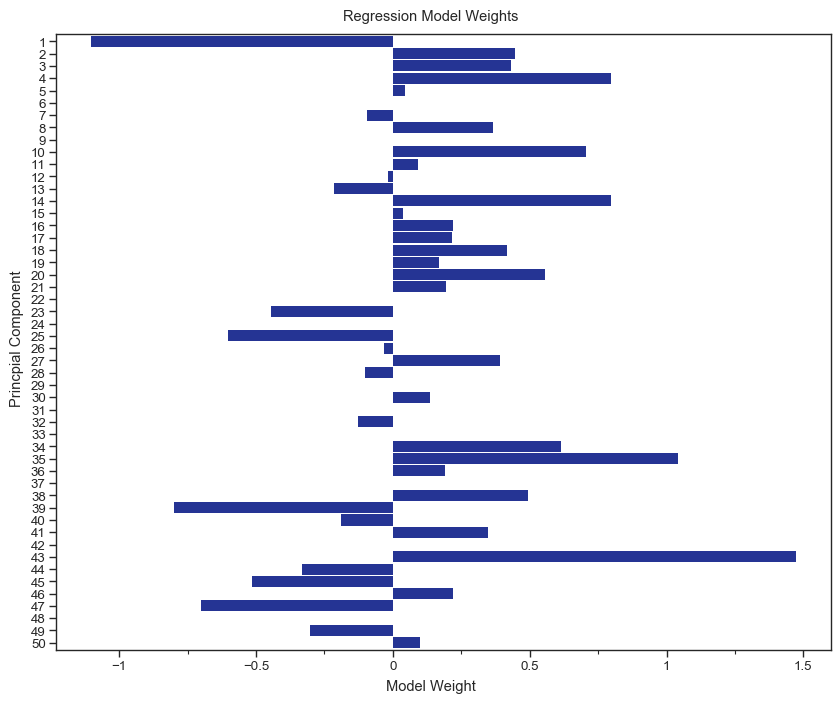

<ggplot: (-9223363263471386375)>


In [31]:
g = (
    p9.ggplot(model_weights_df, p9.aes(x="pc", y="weight"))
    + p9.geom_col(position=p9.position_dodge(width=5), fill="#253494")
    + p9.coord_flip()
    + p9.scale_x_discrete(limits=list(sorted(range(1, 51), reverse=True)))
    + p9.theme_seaborn(context="paper", style="ticks", font_scale=1.1, font="Arial")
    + p9.theme(figure_size=(10, 8))
    + p9.labs(
        title="Regression Model Weights", x="Princpial Component", y="Model Weight"
    )
)
g.save("output/figures/pca_log_regression_weights.svg")
g.save("output/figures/pca_log_regression_weights.png", dpi=250)
print(g)

In [32]:
fold_features = model.coefs_paths_["polka"].transpose(1, 0, 2)
model_performance_df = pd.DataFrame.from_dict(
    {
        "feat_num": ((fold_features.astype(bool).sum(axis=1)) > 0).sum(axis=1),
        "C": model.Cs_,
        "score": model.scores_["polka"].mean(axis=0),
    }
)
model_performance_df.head()

,feat_num,C,score
0,0,0.000100,0.5
1,0,0.000120,0.5
2,0,0.000145,0.5
3,0,0.000175,0.5
4,0,0.000210,0.5


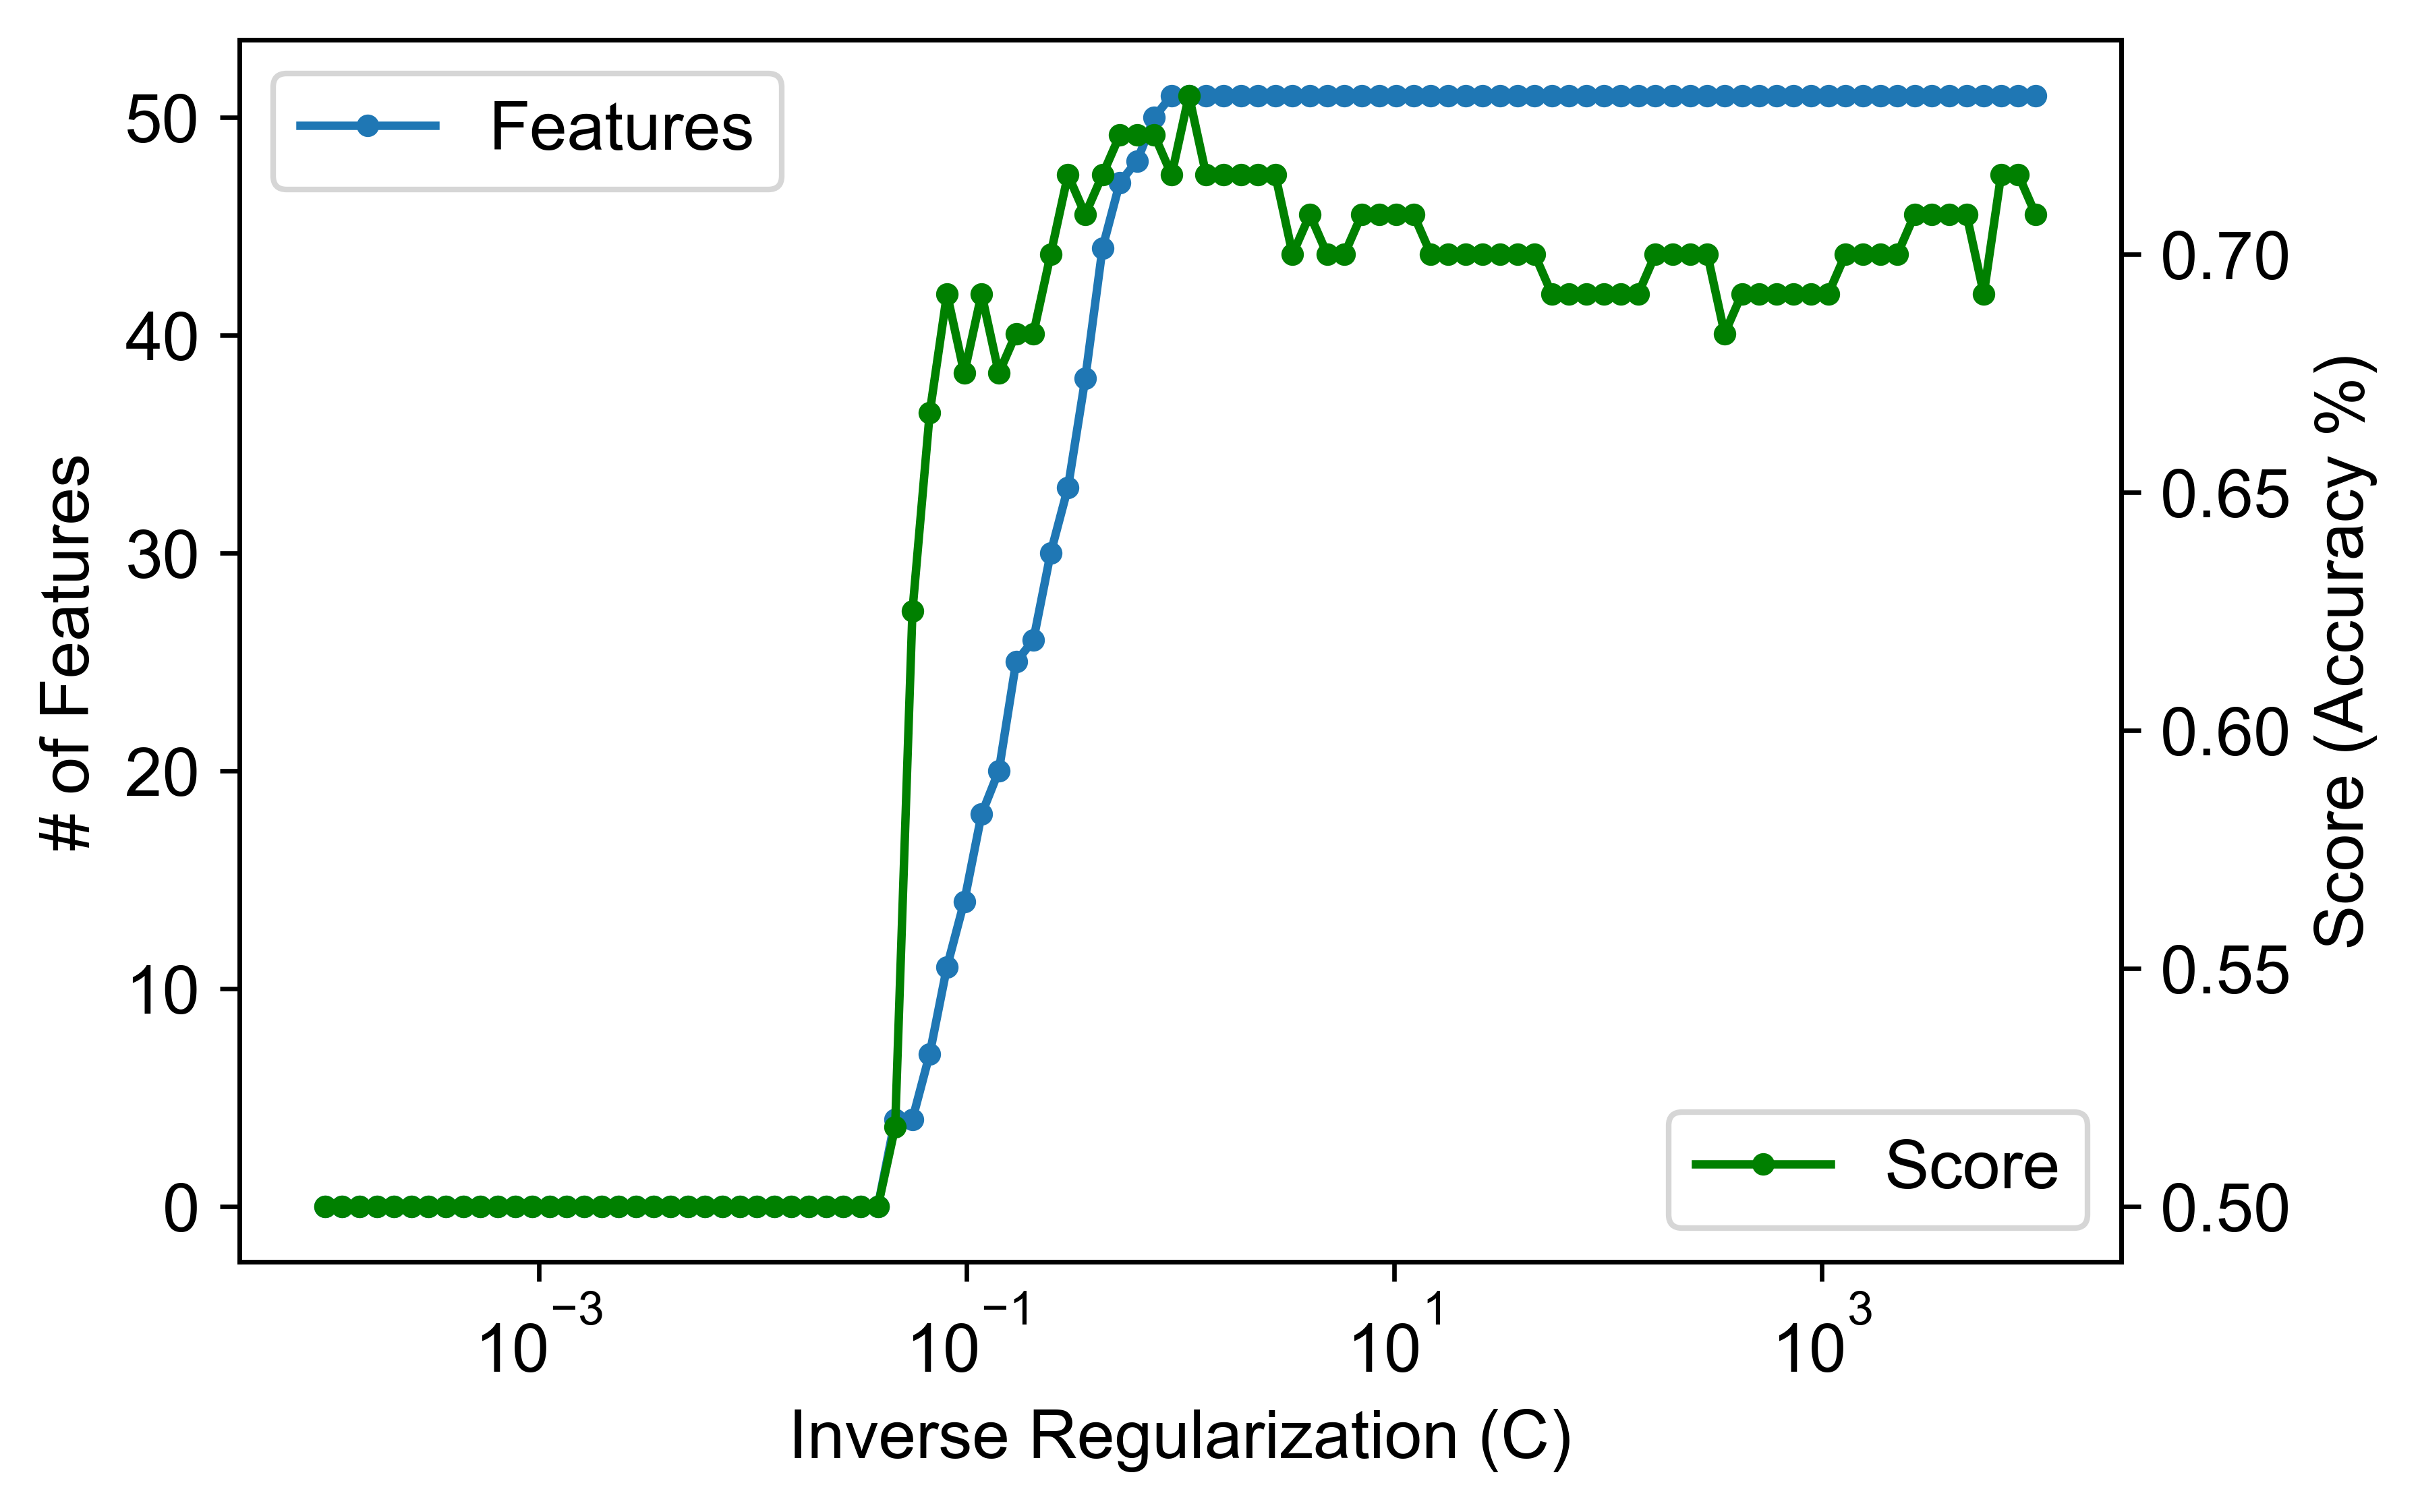

In [33]:
fig, ax1 = plt.subplots()
ax1.set_xscale("log")
ax2 = plt.twinx()

ax1.plot(
    model_performance_df.C.tolist(),
    model_performance_df.feat_num.tolist(),
    label="Features",
    marker=".",
)
ax1.set_ylabel("# of Features")
ax1.set_xlabel("Inverse Regularization (C)")
ax1.legend(loc=0)

ax2.plot(
    model_performance_df.C.tolist(),
    model_performance_df.score.tolist(),
    label="Score",
    marker=".",
    color="green",
)
ax2.set_ylabel("Score (Accuracy %)")
ax2.legend(loc=4)
plt.savefig("output/preprint_classifier_results.png")

In [34]:
plot_path = list(
    zip(
        model.Cs_,
        model.scores_["polka"].transpose(),
        model.coefs_paths_["polka"].transpose(1, 0, 2),
    )
)

In [35]:
data_records = []
for cs in plot_path[33:40]:
    model = LogisticRegression(C=cs[0], max_iter=1000, penalty="l1", solver="liblinear")
    model.fit(
        StandardScaler().fit_transform(dataset_df[[f"pc{idx+1}" for idx in range(50)]]),
        dataset_df["label"],
    )
    data_records.append(
        {
            "C": cs[0],
            "PCs": ",".join(map(str, model.coef_.nonzero()[1] + 1)),
            "feat_num": len(model.coef_.nonzero()[1]),
            "accuracy": cs[1].mean(),
        }
    )

In [36]:
model_coefs_df = pd.DataFrame.from_records(data_records)
model_coefs_df

,C,PCs,feat_num,accuracy
0,0.046416,"12,43,47",3,0.516667
1,0.055908,"10,12,43,47",4,0.625000
2,0.067342,"1,10,12,43,44,47",6,0.666667
3,0.081113,"1,10,12,14,20,34,43,44,47",9,0.691667
4,0.097701,"1,10,12,14,20,34,43,44,47",9,0.675000
5,0.117681,"1,10,12,14,20,34,39,43,44,47",10,0.691667
6,0.141747,"1,4,10,12,13,14,20,25,34,36,39,43,44,46,47",15,0.675000


### Decision Tree

Given that Logistic regression doesn't return sparse weights, we may get better insight into this analysis by using a decision tree to determine which PCs are important in prediction.

In [37]:
model = DecisionTreeClassifier(random_state=100)
search_grid = GridSearchCV(
    model, {"criterion": ["gini", "entropy"], "max_features": ["auto", None]}, cv=10
)
search_grid.fit(dataset_df[[f"pc{idx+1}" for idx in range(50)]], dataset_df["label"])

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', None]})

In [38]:
print(search_grid.best_params_)
print(search_grid.best_score_)

{'criterion': 'entropy', 'max_features': None}
0.675


In [39]:
export_graphviz(
    search_grid.best_estimator_,
    out_file="output/figures/pca_tree.dot",
    feature_names=[f"pc{idx+1}" for idx in range(50)],
    class_names=["bioRxiv", "polka et al."],
    rotate=True,
)

In [40]:
! dot -Tpng output/figures/pca_tree.dot -o output/figures/pca_tree.png

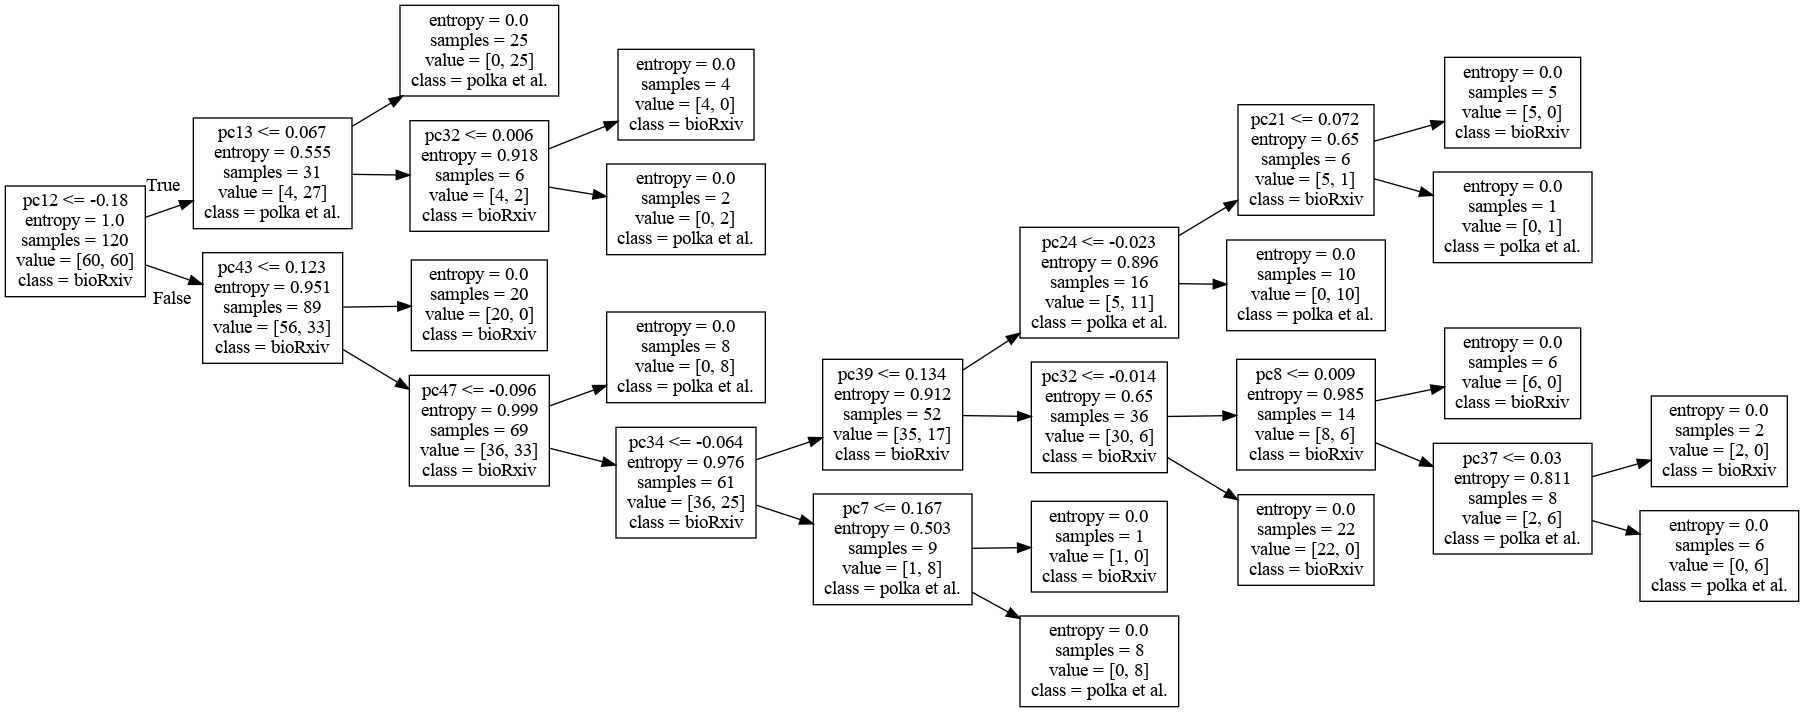

In [41]:
Image(filename="output/figures/pca_tree.png")

## Saucie Subset

Where do the preprints in this subset lie along the SAUCIE map?

In [42]:
saucie_model = SAUCIE(
    300,
    restore_folder=str(Path("../../pmc/journal_recommendation/output/model").resolve()),
)

INFO:tensorflow:Restoring parameters from /home/danich1/Documents/annorxiver/pmc/journal_recommendation/output/model/SAUCIE
Model restored from /home/danich1/Documents/annorxiver/pmc/journal_recommendation/output/model


In [43]:
coordinates = saucie_model.get_embedding(
    Loader(polka_preprints_df.drop("document", axis=1).values)
)

In [44]:
subset_df = pd.DataFrame(coordinates, columns=["dim1", "dim2"])
subset_df.to_csv("output/polka_et_al_saucie_coordinates.tsv", sep="\t", index=False)
subset_df.head()

,dim1,dim2
0,0.824512,-3.278228
1,0.668755,-2.932503
2,-0.022260,-0.972361
3,-0.253317,-0.053676
4,0.133540,-0.392295


In [45]:
pmc_data_df = pd.read_csv(
    Path("../../pmc/journal_recommendation/output")
    / Path("paper_dataset/paper_dataset_full_tsne.tsv"),
    sep="\t",
)
pmc_data_df.head()

,dim1,dim2,journal,document
0,0.750678,2.253210,Environ_Health,PMC1552054
1,1.278987,0.234267,Environ_Health,PMC1226148
2,1.467321,2.177327,Environ_Health,PMC5635510
3,1.437781,3.523604,Environ_Health,PMC3125232
4,0.926364,2.067309,Environ_Health,PMC3533997


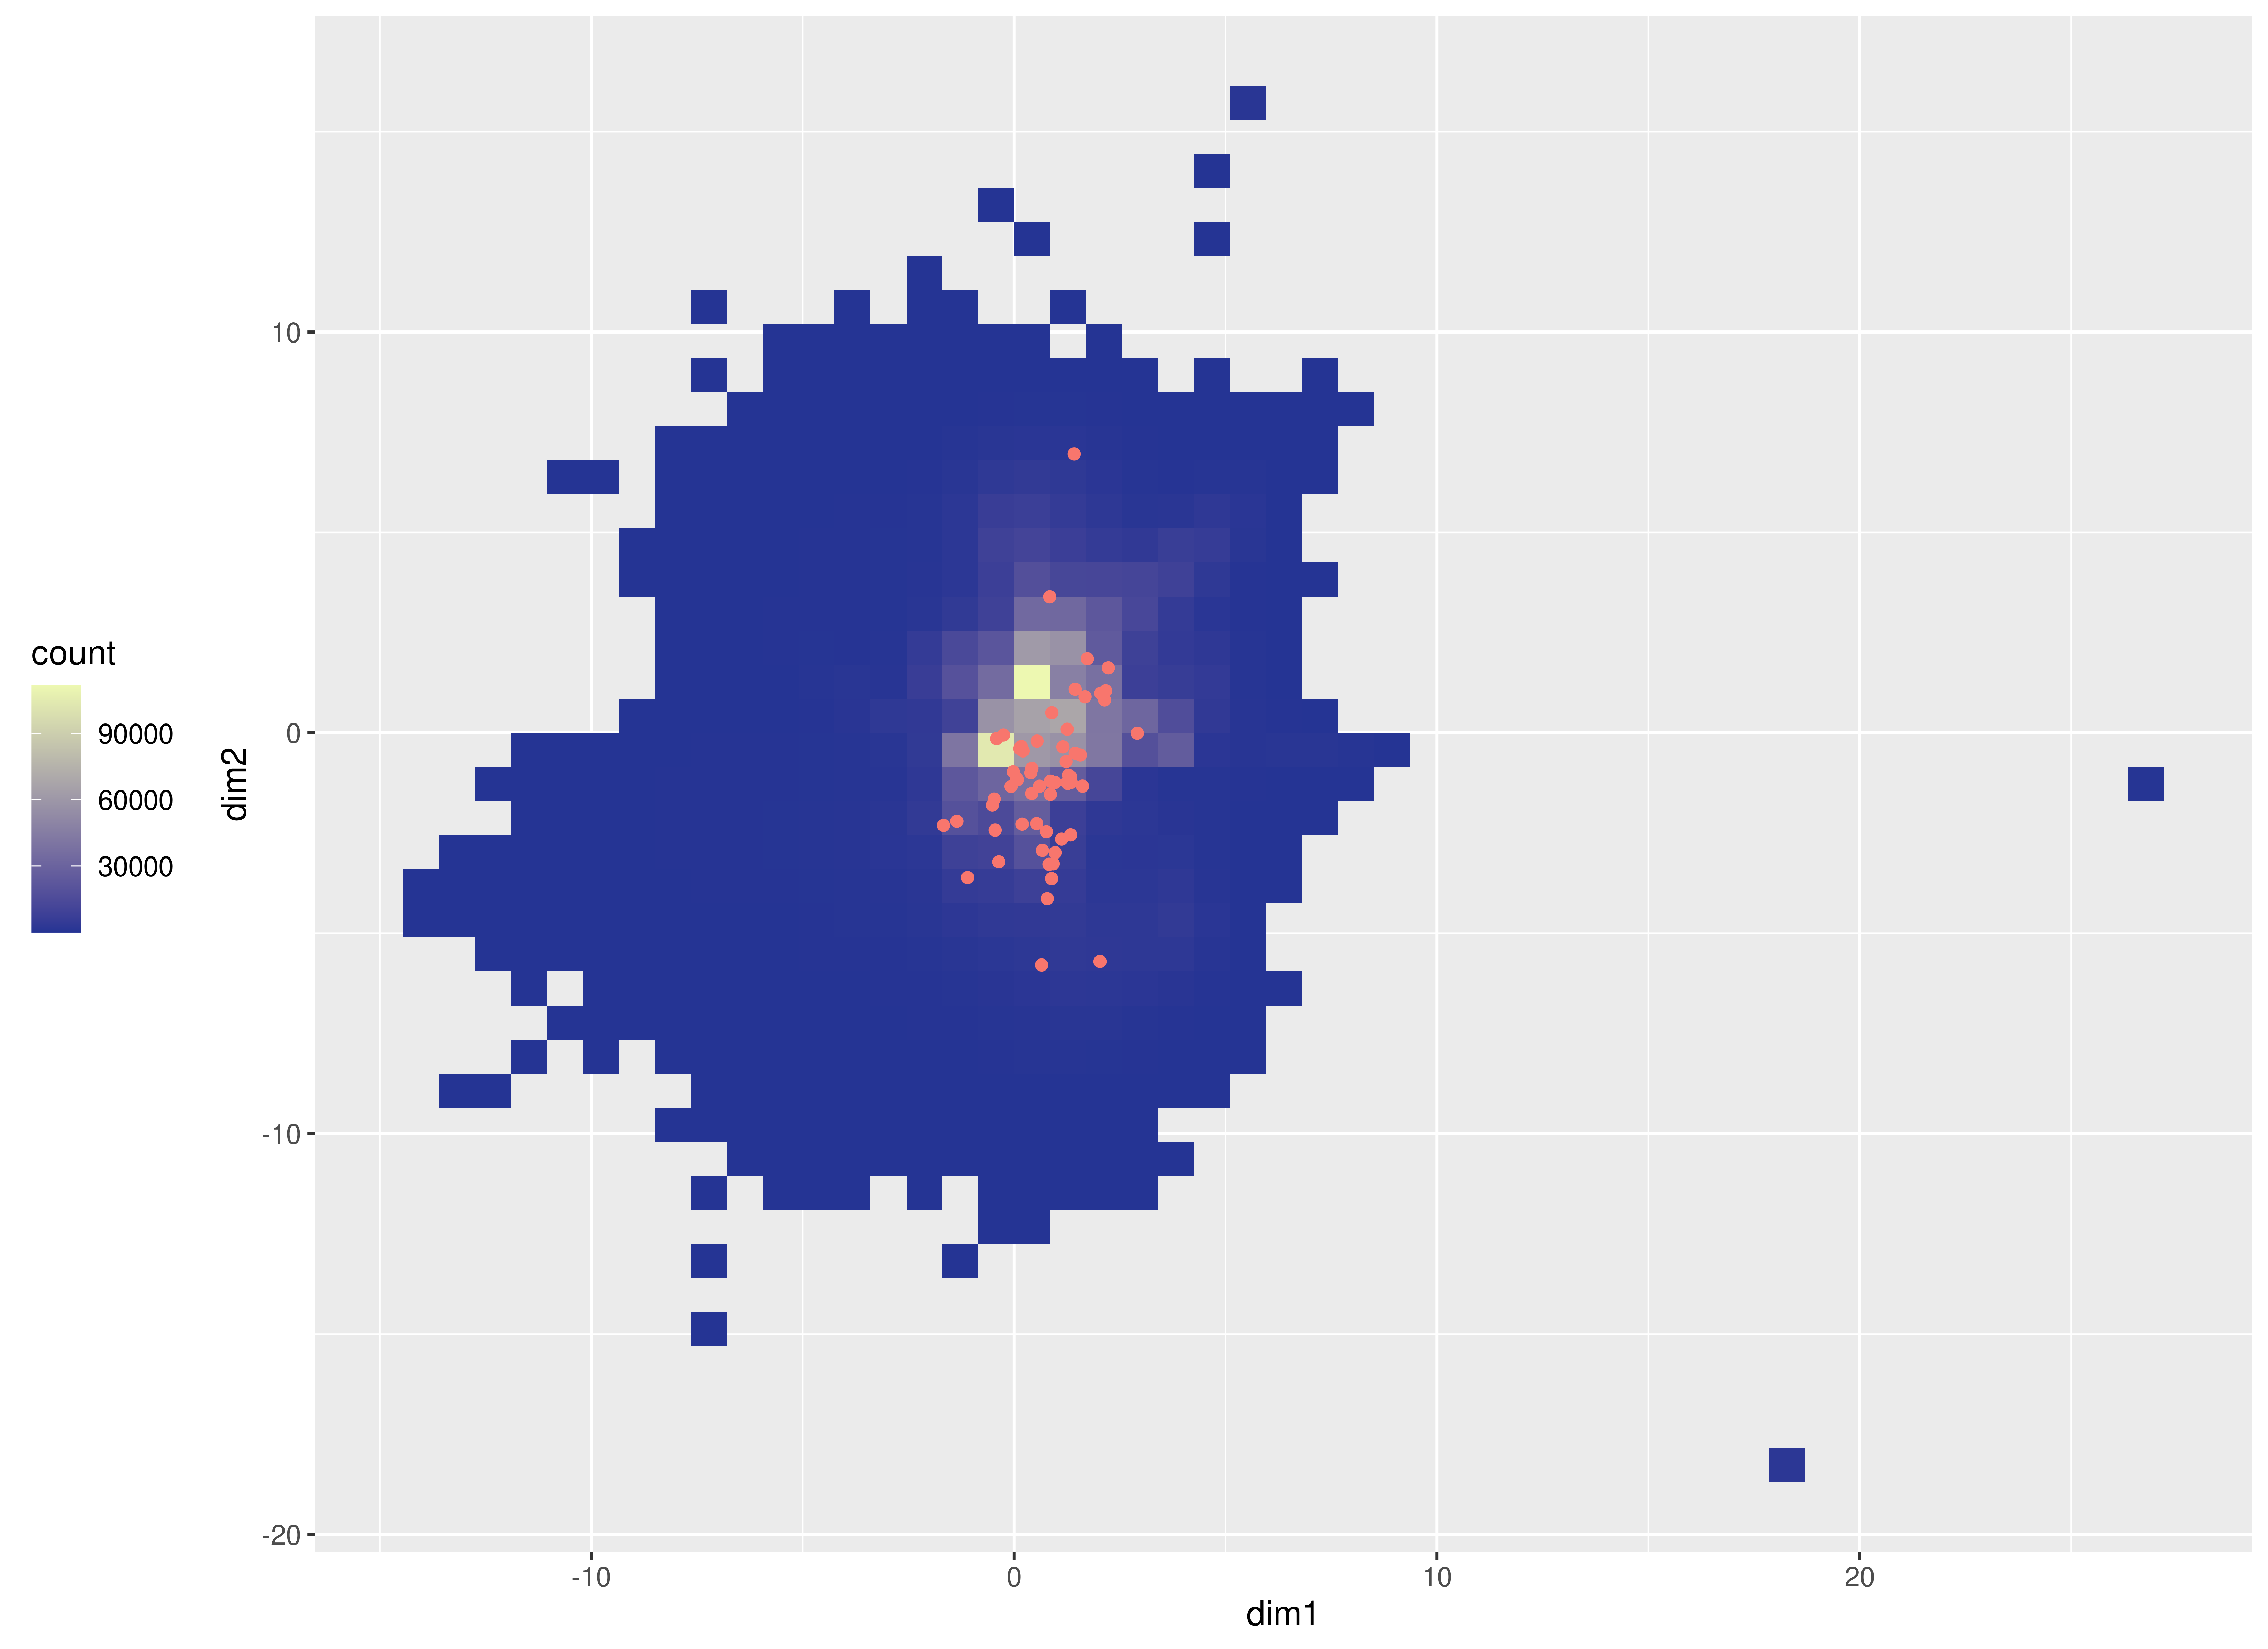

In [46]:
pandas2ri.activate()
robjects.globalenv["pmc_data_df"] = robjects.conversion.py2rpy(pmc_data_df)
robjects.globalenv["subset_df"] = robjects.conversion.py2rpy(subset_df)
robjects.r.source("saucie_plot.R")
Image(filename="output/figures/saucie_plot.png")

In [47]:
# Publication Time Analysis
# Get publication dates
url = "https://api.biorxiv.org/pub/2019-11-01/3000-01-01/"

# Get preprint publication dates for 2019 -> 2020
already_downloaded = Path("output/biorxiv_published_dates_post_2019.tsv").exists()
if not already_downloaded:
    collection = []
    page_size = 100
    total = 23948
    for i in tqdm.tqdm(range(0, total, page_size), total=total / page_size):
        collection += requests.get(url + str(i)).json()["collection"]
    published_dates = pd.DataFrame(collection)
    published_dates.to_csv(
        "output/biorxiv_published_dates_post_2019.tsv", sep="\t", index=False
    )
else:
    published_dates = pd.read_csv(
        "output/biorxiv_published_dates_post_2019.tsv", sep="\t"
    )

published_dates = published_dates.assign(
    preprint_date=lambda x: pd.to_datetime(x.preprint_date.tolist()),
    published_date=lambda x: pd.to_datetime(
        x.published_date.apply(lambda y: y[0 : y.index(":")] if ":" in y else y)
    ),
).assign(time_to_published=lambda x: x.published_date - x.preprint_date)
print(published_dates.shape)
published_dates.head()

(24000, 8)


,biorxiv_doi,published_doi,preprint_title,preprint_category,preprint_date,published_date,published_citation_count,time_to_published
0,10.1101/439315,10.1364/boe.10.000029,"Fast, volumetric live-cell imaging using high-...",bioengineering,2018-10-10,2019-12-04,3,420 days
1,10.1101/256750,10.1093/bioinformatics/bty980,Computational modelling of atherosclerosis: de...,physiology,2018-01-30,2019-12-06,0,675 days
2,10.1101/323154,10.1038/s41467-019-09230-w,Accurate autocorrelation modeling substantiall...,neuroscience,2018-05-16,2019-12-25,0,588 days
3,10.1101/149013,10.1126/sciadv.aat5077,Variable sensitivity to DNA damaging chemother...,systems biology,2017-06-12,2019-12-19,0,920 days
4,10.1101/350538,10.1038/s41591-020-1040-z,Single cell RNAseq provides a molecular and ce...,genomics,2018-06-19,2020-09-14,0,818 days


In [48]:
polka_preprints_df = polka_preprints_df.assign(
    biorxiv_base=lambda x: x.document.apply(lambda y: y.split("_")[0]),
    version_count=lambda x: x.document.apply(
        lambda y: int(y[y.index("v") + 1 :].split(".")[0])
    ),
)
polka_preprints_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299,biorxiv_base,version_count
0,838870_v1.xml,-0.236496,-0.158390,-0.137343,-0.001011,-0.284048,-0.271869,0.041991,0.120466,0.264844,...,0.170882,-0.308521,-0.600287,-0.345592,0.039640,0.730110,-0.348575,0.372932,838870,1
1,2020.02.13.945485_v1.xml,-0.209540,0.062120,-0.013421,-0.000279,-0.314423,-0.326985,0.110545,0.243373,0.338386,...,-0.064431,-0.094898,-0.711048,-0.044813,0.324615,0.655335,-0.402705,0.460434,2020.02.13.945485,1
2,2020.01.13.905190_v1.xml,0.229247,0.103720,-0.675217,-0.279651,0.141527,-0.414926,-0.125090,0.169768,0.501925,...,0.182784,-0.178214,-0.292325,0.067889,0.266495,0.434768,-0.672433,0.628961,2020.01.13.905190,1
3,865089_v1.xml,0.259484,0.187865,-0.476495,0.104272,-0.239906,-0.327997,0.087983,0.278655,0.548521,...,0.137913,-0.376542,-0.662379,-0.009104,0.152630,0.026150,-0.478900,0.473070,865089,1
4,832675_v1.xml,0.331504,0.397300,-0.662221,-0.082239,0.142704,-0.483719,-0.225434,0.289693,0.750071,...,0.369862,-0.425790,-0.461598,-0.768766,0.229174,0.504789,-0.708815,0.094324,832675,1


In [49]:
polka_published_df = pd.read_csv("output/polka_et_al_pmcoa_embeddings.tsv", sep="\t")
polka_published_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,PMC7095418,0.024889,-0.070975,-0.377182,-0.102496,-0.434726,-0.368654,0.028184,0.353945,0.440888,...,0.126341,-0.084509,-0.014971,-0.333411,-0.527903,-0.146963,0.204912,0.419672,-0.734921,0.661554
1,PMC7054013,0.023555,0.215864,-0.443536,0.047643,-0.164215,-0.307564,-0.111106,0.013011,0.214015,...,0.397822,0.087836,0.176272,-0.185256,-0.406073,-0.111970,0.282327,0.564426,-0.316237,0.304340
2,PMC7182430,-0.055630,-0.159898,-0.455295,0.131003,-0.007355,-0.376375,-0.220121,0.168082,0.565368,...,0.225263,-0.107139,0.399253,-0.197415,-0.391321,-0.262596,0.429216,0.556789,-0.663488,0.191001
3,PMC7176908,0.117712,-0.008851,-0.116698,0.319624,-0.250900,-0.397075,0.055953,0.226020,0.259799,...,0.404390,-0.115281,-0.020958,-0.006601,-0.552109,-0.389951,-0.118042,0.743982,-0.158280,0.318420
4,PMC6907167,0.226095,0.161650,-0.382450,0.504041,-0.202860,-0.007196,0.056299,0.074116,0.199937,...,0.228398,0.293127,0.444479,0.206213,-0.649697,0.104617,0.139984,0.281341,-0.474767,0.466702


In [50]:
polka_published_preprint_df = (
    polka_et_al_mapped_df.drop(
        ["Version", "MID", "IsCurrent", "IsLive", "ReleaseDate", "Msg"], axis=1
    )
    .assign(biorxiv_base=lambda x: x.biorxiv_doi.apply(lambda y: y.split("/")[1]))
    .merge(
        polka_preprints_df.drop([f"feat_{idx}" for idx in range(300)], axis=1),
        on="biorxiv_base",
    )
    .drop("document", axis=1)
    .merge(
        published_dates.drop(["published_citation_count", "preprint_title"], axis=1),
        on=["biorxiv_doi", "published_doi"],
    )
    .query(f"PMCID in {polka_published_df['document'].tolist()}")
)
polka_published_preprint_df.head()

,biorxiv_doi,published_doi,PMID,PMCID,biorxiv_base,version_count,preprint_category,preprint_date,published_date,time_to_published
1,10.1101/2019.12.19.882274,10.3389/fpls.2020.00355,32373138.0,PMC7176908,2019.12.19.882274,1,plant biology,2019-12-19,2020-04-16,119 days
4,10.1101/2020.01.22.914952,10.1038/s41586-020-2012-7,32015507.0,PMC7095418,2020.01.22.914952,2,microbiology,2020-01-23,2020-02-03,11 days
5,10.1101/2020.01.22.915660,10.1038/s41564-020-0688-y,32094589.0,PMC7095430,2020.01.22.915660,1,microbiology,2020-01-22,2020-02-24,33 days
6,10.1101/2020.01.23.916395,10.1016/j.ijid.2020.01.050,32007643.0,PMC7110798,2020.01.23.916395,2,ecology,2020-01-24,2020-01-30,6 days
7,10.1101/2020.01.24.915157,10.1002/jmv.25688,31994738.0,PMC7166400,2020.01.24.915157,1,bioinformatics,2020-01-24,2020-01-29,5 days


In [51]:
for col in ["preprint_date", "published_date"]:
    polka_published_preprint_df[col] = pd.to_datetime(polka_published_preprint_df[col])

polka_published_preprint_df["time_to_published"] = pd.to_timedelta(
    polka_published_preprint_df["time_to_published"]
)
polka_published_preprint_df["days_to_published"] = polka_published_preprint_df[
    "time_to_published"
].dt.days
print(polka_published_preprint_df.shape)
polka_published_preprint_df.to_csv(
    "output/polka_preprint_published_distances.tsv", sep="\t"
)
polka_published_preprint_df.head()

(39, 11)


,biorxiv_doi,published_doi,PMID,PMCID,biorxiv_base,version_count,preprint_category,preprint_date,published_date,time_to_published,days_to_published
1,10.1101/2019.12.19.882274,10.3389/fpls.2020.00355,32373138.0,PMC7176908,2019.12.19.882274,1,plant biology,2019-12-19,2020-04-16,119 days,119
4,10.1101/2020.01.22.914952,10.1038/s41586-020-2012-7,32015507.0,PMC7095418,2020.01.22.914952,2,microbiology,2020-01-23,2020-02-03,11 days,11
5,10.1101/2020.01.22.915660,10.1038/s41564-020-0688-y,32094589.0,PMC7095430,2020.01.22.915660,1,microbiology,2020-01-22,2020-02-24,33 days,33
6,10.1101/2020.01.23.916395,10.1016/j.ijid.2020.01.050,32007643.0,PMC7110798,2020.01.23.916395,2,ecology,2020-01-24,2020-01-30,6 days,6
7,10.1101/2020.01.24.915157,10.1002/jmv.25688,31994738.0,PMC7166400,2020.01.24.915157,1,bioinformatics,2020-01-24,2020-01-29,5 days,5


### Document version count plot

In [52]:
biorxiv_published_distances = pd.read_csv(
    "../publication_delay_experiment/output/preprint_published_distances.tsv",
    sep="\t",
)
biorxiv_published_distances["time_to_published"] = pd.to_timedelta(
    biorxiv_published_distances["time_to_published"]
)
biorxiv_published_distances["days_to_published"] = biorxiv_published_distances[
    "time_to_published"
].dt.days
biorxiv_published_distances = biorxiv_published_distances.query("days_to_published > 0")
biorxiv_published_distances.head()

,preprint_doi,document,category,version_count,published_doi,pmcid,pmcoa,journal,preprint_date,published_date,time_to_published,doc_distances,days_to_published
0,10.1101/000026,000026_v1.xml,genetics,1,10.1371/journal.pgen.1004412,PMC4125079,True,PLoS_Genet,2013-11-07,2014-08-07,273 days,1.360377,273
1,10.1101/000067,000067_v1.xml,genomics,1,10.1038/nature12904,PMC4285441,True,Nature,2013-11-07,2014-02-27,112 days,0.470905,112
2,10.1101/000109,000109_v1.xml,evolutionary biology,1,10.1371/journal.pgen.1004410,PMC4072524,True,PLoS_Genet,2013-11-07,2014-06-26,231 days,0.533702,231
3,10.1101/000141,000141_v1.xml,cancer biology,1,10.1371/journal.pcbi.1003433,PMC3894166,True,PLoS_Comput_Biol,2013-11-07,2014-01-16,70 days,0.646077,70
4,10.1101/000158,000158_v1.xml,bioinformatics,1,10.1186/1471-2164-15-398,PMC4041996,True,BMC_Genomics,2013-11-11,2014-05-24,194 days,0.959715,194


In [53]:
# Get smoothed linear regression line
x = biorxiv_published_distances.version_count.values.tolist()

y = biorxiv_published_distances.time_to_published.apply(
    lambda x: x / timedelta(days=1)
).tolist()

xseq_2 = np.linspace(np.min(x), np.max(x), 80)

results_2 = linregress(x, y)
print(results_2)

LinregressResult(slope=50.623411131535995, intercept=133.68149048818225, rvalue=0.3036436427205601, pvalue=0.0, stderr=1.2009171466339463, intercept_stderr=2.0360365185236304)


In [54]:
x_line = np.array(
    [
        biorxiv_published_distances["version_count"].min(),
        biorxiv_published_distances["version_count"].max(),
    ]
)
y_line = x_line * results_2.slope + results_2.intercept

In [55]:
# Get smoothed linear regression line
polka_x = polka_published_preprint_df.version_count.values.tolist()

polka_y = polka_published_preprint_df.time_to_published.apply(
    lambda x: x / timedelta(days=1)
).tolist()

xseq_2 = np.linspace(np.min(x), np.max(x), 80)

results_3 = linregress(polka_x, polka_y)
print(results_3)

LinregressResult(slope=-2.7000000000000006, intercept=56.753846153846155, rvalue=-0.03533588115825079, pvalue=0.8308906713676564, stderr=12.553813478311392, intercept_stderr=18.642003871150774)


In [56]:
polka_x_line = np.array(
    [
        polka_published_preprint_df["version_count"].min(),
        polka_published_preprint_df["version_count"].max(),
    ]
)
polka_y_line = polka_x_line * results_3.slope + results_3.intercept

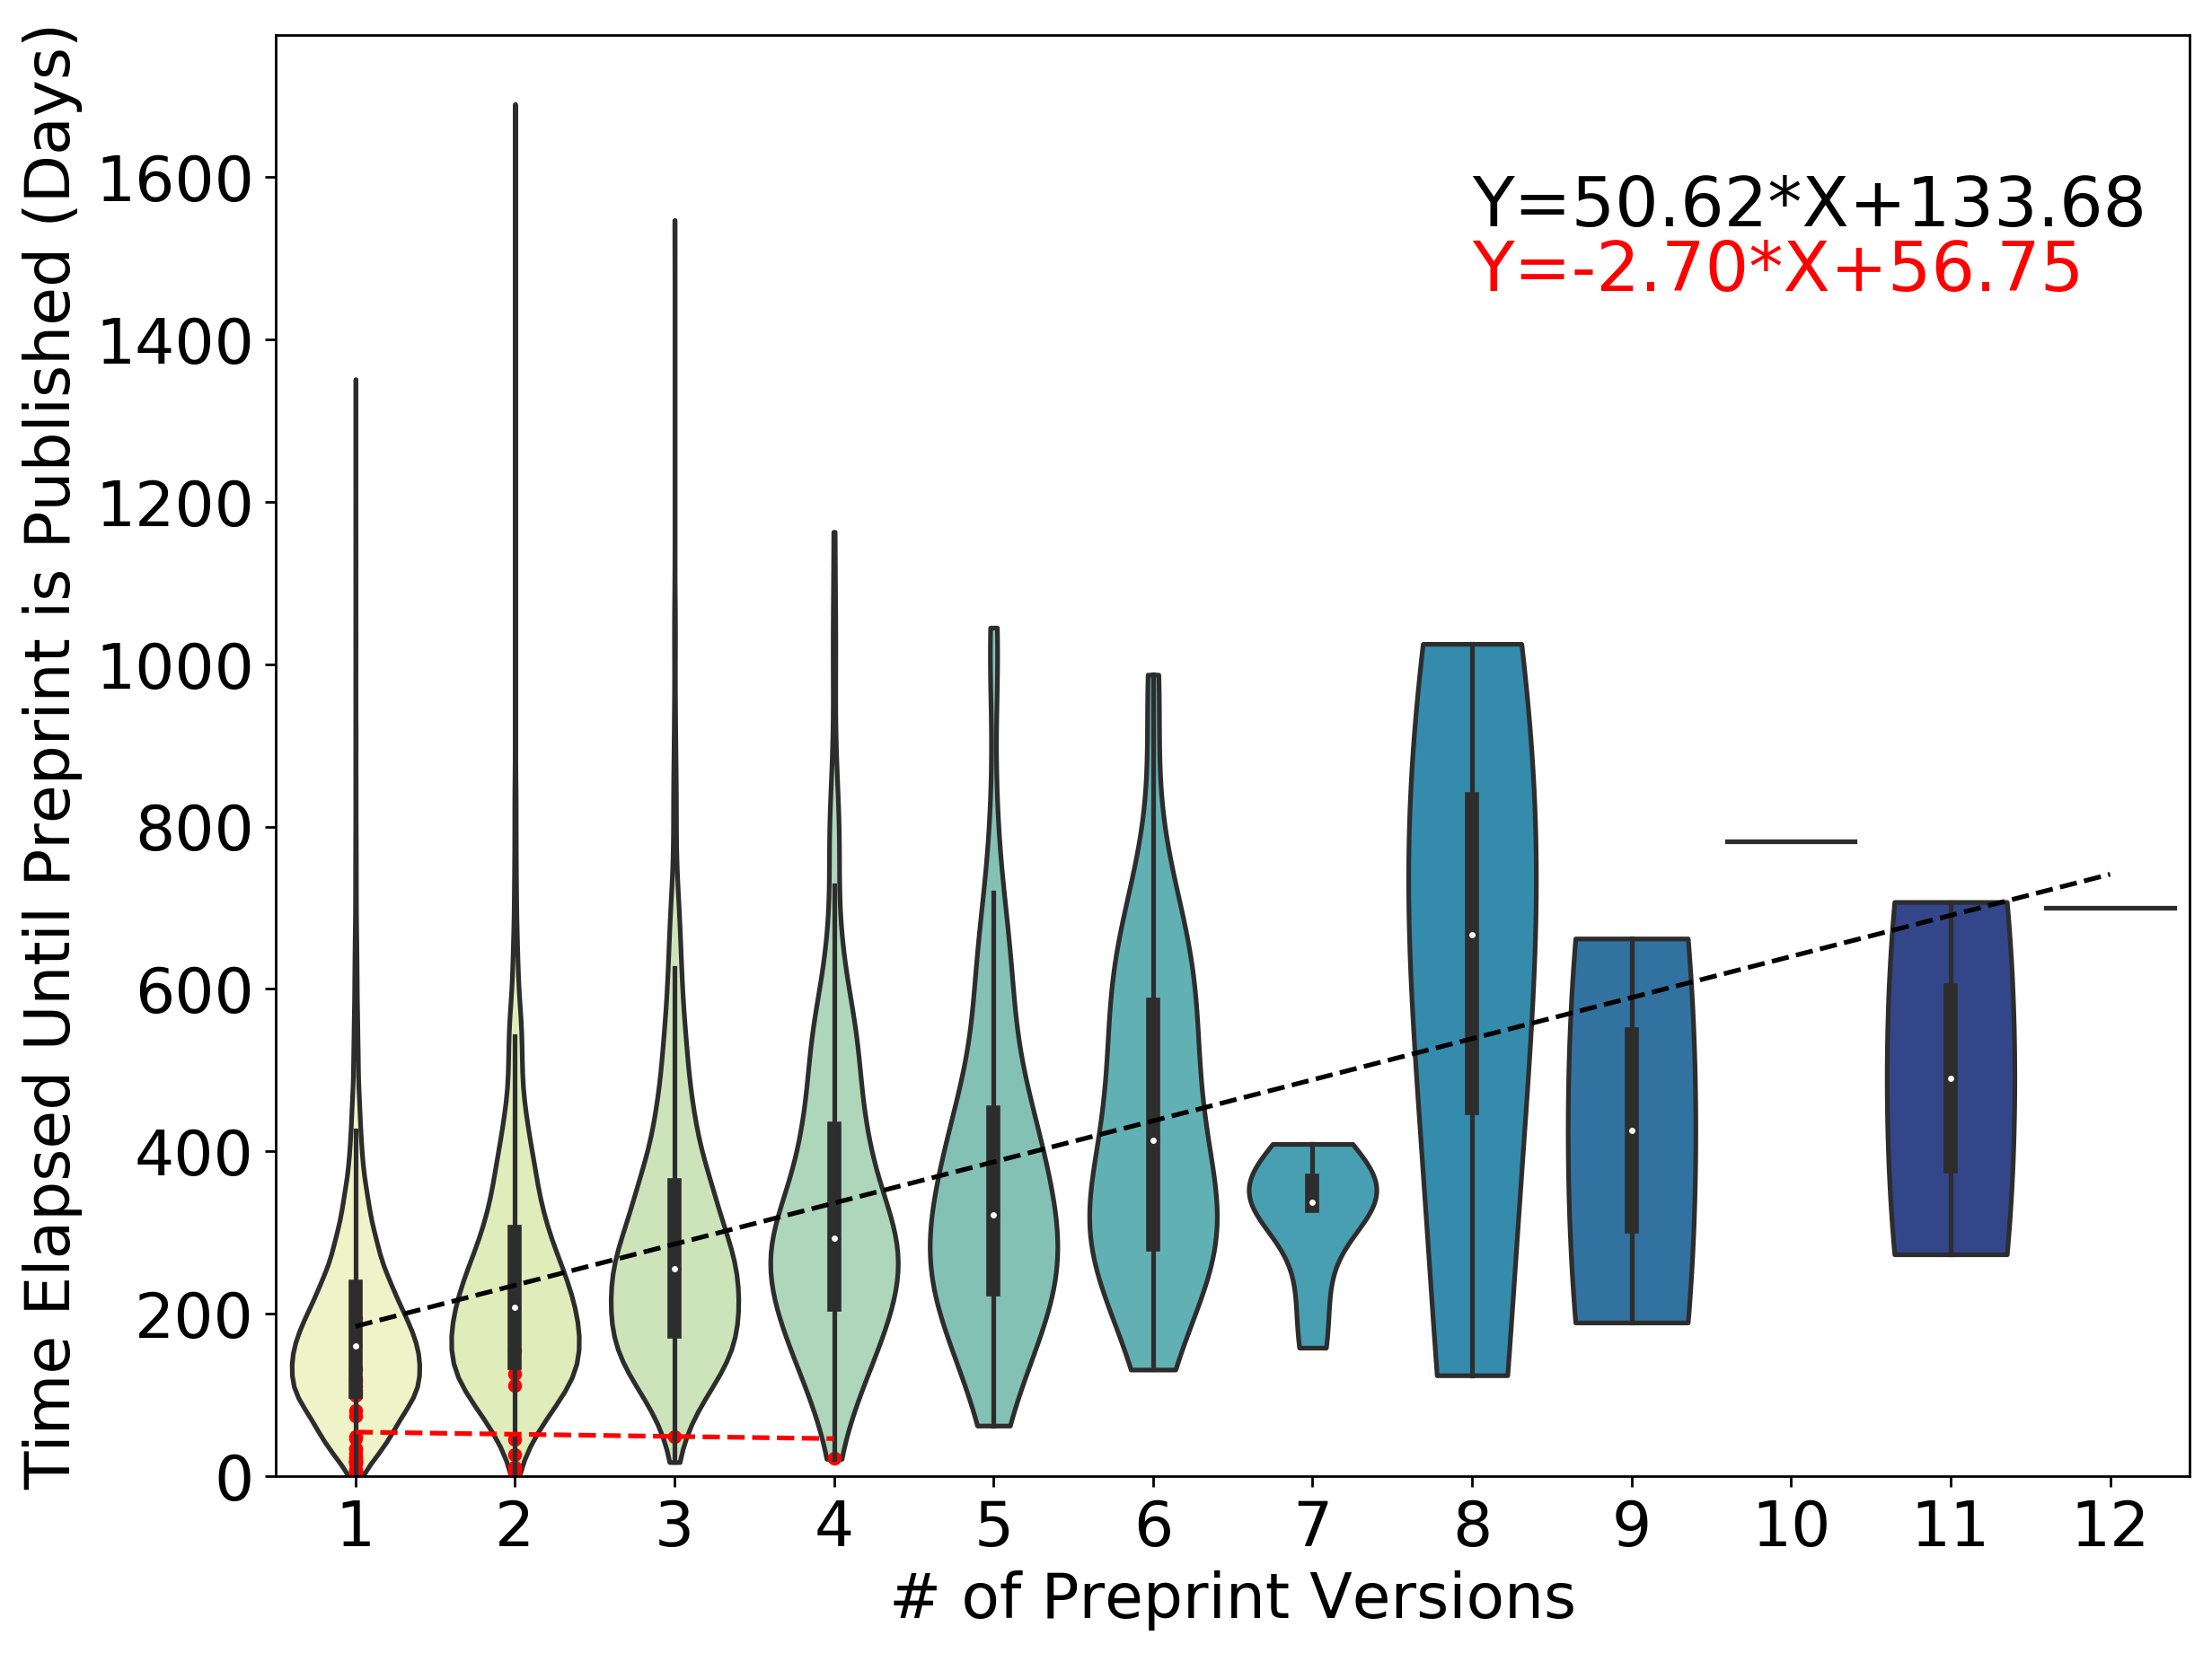

In [57]:
# Graph here?
plt.figure(figsize=(11, 8.5))
plt.rcParams.update({"font.size": 22})
g = sns.violinplot(
    x="version_count",
    y="days_to_published",
    data=biorxiv_published_distances,
    cut=0,
    scale="width",
    palette="YlGnBu",
)

_ = g.set_ylabel("Time Elapsed Until Preprint is Published (Days)")
_ = g.set_xlabel("# of Preprint Versions")
_ = g.plot(x_line - 1, y_line, "--k")
_ = g.plot(polka_x_line - 1, polka_y_line, "--k", color="red")
_ = g.scatter(
    polka_published_preprint_df["version_count"] - 1,
    polka_published_preprint_df["days_to_published"],
    c="red",
    s=12,
)
_ = g.annotate(f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}", (7, 1540))
_ = g.annotate(
    f"Y={results_3.slope:.2f}*X+{results_3.intercept:.2f}", (7, 1460), color="red"
)
_ = g.set_xlim(-0.5, 11.5)
_ = g.set_ylim(0, g.get_ylim()[1])

ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax.xaxis.label.set_size(20)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax.yaxis.label.set_size(20)

plt.savefig("output/figures/version_count_vs_publication_time_violin.svg", dpi=500)
plt.savefig("output/figures/version_count_vs_publication_time_violin.png", dpi=500)

### Document embedding pair

In [58]:
polka_published_df = polka_published_df.set_index("document")
polka_published_df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
document,,,,,,,,,,,,,,,,,,,,,
PMC7095418,0.024889,-0.070975,-0.377182,-0.102496,-0.434726,-0.368654,0.028184,0.353945,0.440888,-0.218257,...,0.126341,-0.084509,-0.014971,-0.333411,-0.527903,-0.146963,0.204912,0.419672,-0.734921,0.661554
PMC7054013,0.023555,0.215864,-0.443536,0.047643,-0.164215,-0.307564,-0.111106,0.013011,0.214015,-0.560381,...,0.397822,0.087836,0.176272,-0.185256,-0.406073,-0.111970,0.282327,0.564426,-0.316237,0.304340
PMC7182430,-0.055630,-0.159898,-0.455295,0.131003,-0.007355,-0.376375,-0.220121,0.168082,0.565368,-0.253361,...,0.225263,-0.107139,0.399253,-0.197415,-0.391321,-0.262596,0.429216,0.556789,-0.663488,0.191001
PMC7176908,0.117712,-0.008851,-0.116698,0.319624,-0.250900,-0.397075,0.055953,0.226020,0.259799,-0.583976,...,0.404390,-0.115281,-0.020958,-0.006601,-0.552109,-0.389951,-0.118042,0.743982,-0.158280,0.318420
PMC6907167,0.226095,0.161650,-0.382450,0.504041,-0.202860,-0.007196,0.056299,0.074116,0.199937,-0.492770,...,0.228398,0.293127,0.444479,0.206213,-0.649697,0.104617,0.139984,0.281341,-0.474767,0.466702


In [59]:
polka_preprints_df = polka_preprints_df.set_index("biorxiv_base").drop(
    ["document", "version_count"], axis=1
)
polka_preprints_df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
biorxiv_base,,,,,,,,,,,,,,,,,,,,,
838870,-0.236496,-0.158390,-0.137343,-0.001011,-0.284048,-0.271869,0.041991,0.120466,0.264844,-0.323787,...,0.125062,-0.135080,0.170882,-0.308521,-0.600287,-0.345592,0.039640,0.730110,-0.348575,0.372932
2020.02.13.945485,-0.209540,0.062120,-0.013421,-0.000279,-0.314423,-0.326985,0.110545,0.243373,0.338386,-0.218816,...,-0.119528,0.035750,-0.064431,-0.094898,-0.711048,-0.044813,0.324615,0.655335,-0.402705,0.460434
2020.01.13.905190,0.229247,0.103720,-0.675217,-0.279651,0.141527,-0.414926,-0.125090,0.169768,0.501925,-0.420740,...,0.282492,0.042949,0.182784,-0.178214,-0.292325,0.067889,0.266495,0.434768,-0.672433,0.628961
865089,0.259484,0.187865,-0.476495,0.104272,-0.239906,-0.327997,0.087983,0.278655,0.548521,-0.367887,...,0.273547,0.442512,0.137913,-0.376542,-0.662379,-0.009104,0.152630,0.026150,-0.478900,0.473070
832675,0.331504,0.397300,-0.662221,-0.082239,0.142704,-0.483719,-0.225434,0.289693,0.750071,-0.407192,...,0.357520,0.031200,0.369862,-0.425790,-0.461598,-0.768766,0.229174,0.504789,-0.708815,0.094324


In [60]:
dist = np.diag(
    cdist(
        polka_preprints_df.loc[polka_published_preprint_df["biorxiv_base"]],
        polka_published_df.loc[polka_published_preprint_df["PMCID"]],
    )
)
print(dist)

[0.47375936 2.04539275 0.70668387 1.4625662  0.90859246 0.62022391
 1.80517667 0.36020873 0.50003877 0.92829635 0.99207876 1.91494677
 0.53140412 0.82485557 1.61339151 7.14830682 1.66733865 0.75922853
 0.89680648 0.25934241 1.85628842 0.85458801 0.89741978 0.4389725
 0.6269485  1.30826854 1.51865366 0.54117937 1.39345712 0.71481943
 0.36820635 2.40695611 0.43842842 1.83987354 0.50578827 0.82714682
 2.06052392 1.64974604 0.29296408]


In [61]:
polka_published_preprint_df = polka_published_preprint_df.assign(doc_distances=dist)
polka_published_preprint_df.head()

,biorxiv_doi,published_doi,PMID,PMCID,biorxiv_base,version_count,preprint_category,preprint_date,published_date,time_to_published,days_to_published,doc_distances
1,10.1101/2019.12.19.882274,10.3389/fpls.2020.00355,32373138.0,PMC7176908,2019.12.19.882274,1,plant biology,2019-12-19,2020-04-16,119 days,119,0.473759
4,10.1101/2020.01.22.914952,10.1038/s41586-020-2012-7,32015507.0,PMC7095418,2020.01.22.914952,2,microbiology,2020-01-23,2020-02-03,11 days,11,2.045393
5,10.1101/2020.01.22.915660,10.1038/s41564-020-0688-y,32094589.0,PMC7095430,2020.01.22.915660,1,microbiology,2020-01-22,2020-02-24,33 days,33,0.706684
6,10.1101/2020.01.23.916395,10.1016/j.ijid.2020.01.050,32007643.0,PMC7110798,2020.01.23.916395,2,ecology,2020-01-24,2020-01-30,6 days,6,1.462566
7,10.1101/2020.01.24.915157,10.1002/jmv.25688,31994738.0,PMC7166400,2020.01.24.915157,1,bioinformatics,2020-01-24,2020-01-29,5 days,5,0.908592


In [62]:
# Get smoothed linear regression line
x = biorxiv_published_distances.doc_distances.values.tolist()

y = biorxiv_published_distances.time_to_published.apply(
    lambda x: x / timedelta(days=1)
).tolist()

xseq_2 = np.linspace(np.min(x), np.max(x), 80)

results_2 = linregress(x, y)
print(results_2)

LinregressResult(slope=43.27393641523755, intercept=168.94390477104105, rvalue=0.1994119912464653, pvalue=2.080656543927908e-156, stderr=1.6076610172681676, intercept_stderr=1.7910675887946146)


In [63]:
x_line = np.array(
    [
        biorxiv_published_distances["doc_distances"].min(),
        biorxiv_published_distances["doc_distances"].max(),
    ]
)
y_line = x_line * results_2.slope + results_2.intercept

In [64]:
polka_x = (polka_published_preprint_df["doc_distances"].values.tolist(),)
polka_y = polka_published_preprint_df.time_to_published.apply(
    lambda x: x / timedelta(days=1)
).tolist()

results_3 = linregress(polka_x, polka_y)
print(results_3)

LinregressResult(slope=-1.5582234462286726, intercept=55.030061754432246, rvalue=-0.03517618439687711, pvalue=nan, stderr=nan, intercept_stderr=nan)


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:174: RuntimeWarning: invalid value encountered in sqrt
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:176: RuntimeWarning: invalid value encountered in sqrt


In [65]:
polka_x_line = np.array(
    [
        polka_published_preprint_df["doc_distances"].min(),
        polka_published_preprint_df["doc_distances"].max(),
    ]
)
polka_y_line = polka_x_line * results_3.slope + results_3.intercept

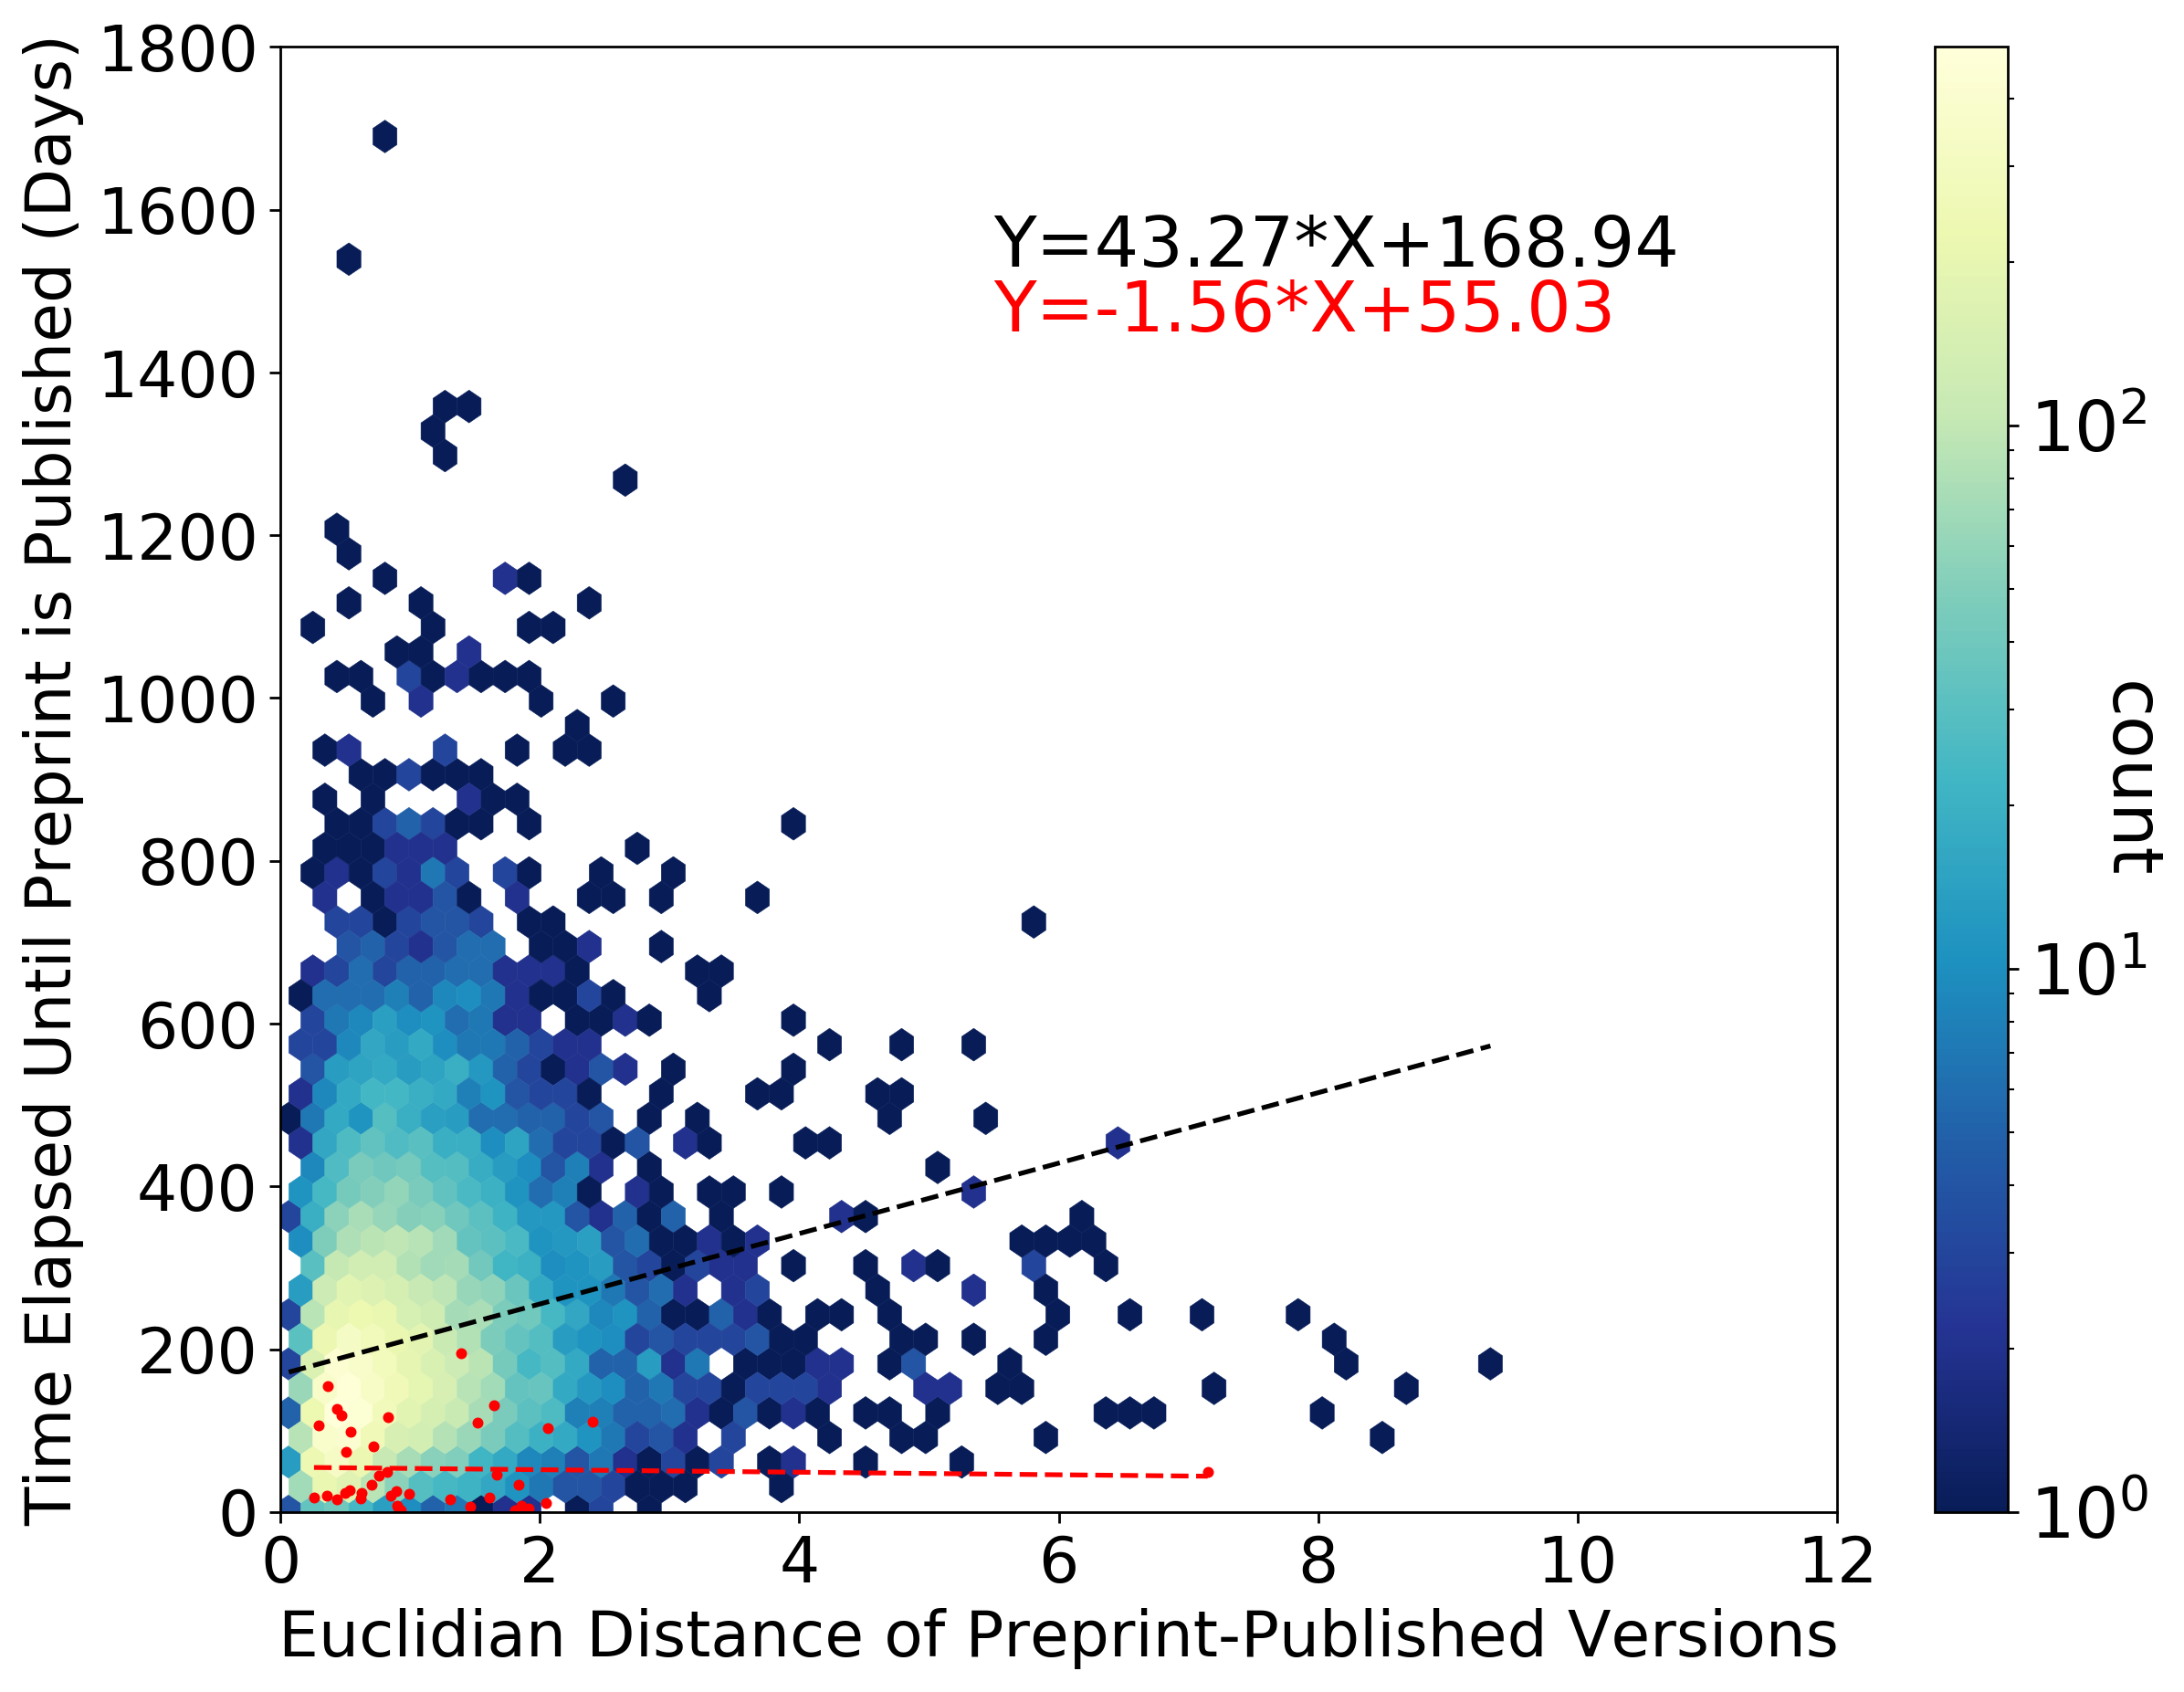

In [66]:
# graph here?
plt.figure(figsize=(11, 8.5))
plt.rcParams.update({"font.size": 22})
ax = plt.hexbin(
    biorxiv_published_distances["doc_distances"],
    biorxiv_published_distances["days_to_published"],
    gridsize=50,
    cmap="YlGnBu_r",
    norm=mpl.colors.LogNorm(),
    mincnt=1,
    linewidths=(0.15,)
    #     edgecolors=None
)
plt.xlim([0, 12])
plt.ylim([0, 1800])
ax = plt.gca()

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax.xaxis.label.set_size(20)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax.yaxis.label.set_size(20)

ax.plot(x_line, y_line, "--k")
ax.plot(polka_x_line, polka_y_line, "--k", color="red")
ax.annotate(
    f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}",
    (5.5, 1530),
)
_ = ax.annotate(
    f"Y={results_3.slope:.2f}*X+{results_3.intercept:.2f}", (5.5, 1450), color="red"
)
_ = ax.set_xlabel("Euclidian Distance of Preprint-Published Versions")
_ = ax.set_ylabel("Time Elapsed Until Preprint is Published (Days)")
cbar = plt.colorbar()
_ = cbar.ax.set_ylabel("count", rotation=270)
_ = ax.scatter(
    polka_published_preprint_df["doc_distances"],
    polka_published_preprint_df["days_to_published"],
    c="red",
    s=6,
)
plt.savefig("output/figures/article_distance_vs_publication_time_hex.svg", dpi=250)
plt.savefig("output/figures/article_distance_vs_publication_time_hex.png", dpi=250)